### Use Machine Learning to predict the probability of needing Post-Mastectomy Radiotherapy
Author: Yifu (Charles) Chen

A notebook in Python Language

In [1]:
### Import modules ###
import os
import glob
import pandas as pd
import numpy as np
from typing import Dict
import re
import copy
# Machine Learning Modules for Random Forest, Logistic Regression, and XGBoost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# Metrics
from sklearn import metrics

### Utils

In [2]:
# Setup no print limits and etc.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

class bcolors:
    # Helper class to print in terminal with colors
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    NORMAL = '\033[0m'

In [3]:
from collections import OrderedDict

# Directory of DataFrames
dir_to_df = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/output/2022-07-13-133052_without_imputation/DataFrames/subset_dataframes"

# Path to log file
log_path = os.path.join(dir_to_df, "log.txt")

# Create a new log file from scratch, regardless if one exists
with open(log_path, "w") as log_file:
    log_file.write("")

def print_and_log(*args, **kwargs):
    # Helper function to print and log
    # Can handle writing DataFrame to log file
    print(*args, **kwargs)
    with open(log_path, "a") as log_file:
        if type(args[0]) == pd.DataFrame:
            log_file.write(args[0].to_string() + "\n")
        else:
            log_file.write("|| ".join([str(a) for a in args]) + "\n")

    
# Assume all files in directory are CSV DataFrame files
paths_to_df = glob.glob(os.path.join(dir_to_df, "*.csv"))

# Read each DataFrame file
dfs = OrderedDict()
for i, path in enumerate(paths_to_df):
    df_name = path.replace(dir_to_df, "")
    df_name = df_name.replace("/", "").replace(".csv", "")
    df = pd.read_csv(path)
    if i == len(paths_to_df) - 1:
        print("Kept the largest DF")
        df_all = df.copy()
        # dfs["df_all"] = df
    # Drop "PRE_record_id" column, if it exists
    if "PRE_record_id" in df.columns:
        df = df.drop(columns=["PRE_record_id"], axis=1)
    dfs[df_name] = df
# Sorted the dict by path name
dfs = OrderedDict(sorted(dfs.items()))

for k in dfs.keys():
    print_and_log(k)
    



Kept the largest DF
0_PRE-alan-heuristic7cols
1_PRE-expert-imputed25cols
2_PRE-expert-picked36cols
3_PRE-expert-imputed-preprocessed25cols
4_PRE-expert-imputed-enhanced-preprocessed36cols
5_PRE-0.05spars-expert-ML-imputed76cols
6_PRE-0.2spars-expert-ML-imputed77cols
7_PRE-0.5spars-expert-ML-imputed79cols
8_PRE-0.8spars-expert-ML-imputed83cols
9_PRE-1.0spars-expert-ML-imputed89cols
A_POS-0.05spars-expert-ML-imputed94cols
B_POS-0.2spars-expert-ML-imputed103cols
C_POS-0.5spars-expert-ML-imputed113cols
D_POS-0.8spars-expert-ML-imputed122cols
E_POS-1.0spars-expert-ML-imputed132cols


### Pre-Process Datasets

In [4]:
# Standardize the data by removing the mean and scaling to unit variance
# The target variable is named "POS_did_the_patient_receive_pm"

dfs_std = OrderedDict()

for df_name, df in dfs.items():
    # Standardize all columns except the target column "POS_did_the_patient_receive_pm"
    df_std = df.copy()
    df_std.drop(["POS_did_the_patient_receive_pm"], axis=1, inplace=True)
    df_std = (df_std - df_std.mean()) / df_std.std()
    df_std = df_std.copy()
    # Concatenate the target column back
    df_std["POS_did_the_patient_receive_pm"] = df["POS_did_the_patient_receive_pm"]
    # Convert the target column to binary
    df_std["POS_did_the_patient_receive_pm"] = df_std["POS_did_the_patient_receive_pm"] > 0
    dfs_std[df_name] = df_std

len(dfs_std)

15

### Build Machine Learning Classifiers

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:


# Initialize a dictionary for holding the models for each DataFrame
# Schema: {"DataFrame Name": {"Model Name": Model Object, ...}, ...}
from collections import defaultdict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
import itertools

all_models = defaultdict(dict)

# The print_df contains the dataframe, model, and the average CV accuracy, AUC, and the top 6 features and their scores
# metrics_df_columns = ["Dataset", "Model", "Avg CV Accuracy", "Avg CV AUC", "Avg CV F1", "Feature_1", "Score_1", "Feature_2", "Score_2", 
#                     "Feature_3", "Score_3", "Feature_4", "Score_4", "Feature_5", "Score_5", "Feature_6", "Score_6"]

metrics_df_columns = ["Dataset", "Model"] + list(itertools.chain(*[["Avg " + m, "SE " + m] for m in ["Accuracy", "AUC", "F1"]]))

def build_classifiers(df: pd.DataFrame, df_name: str, num_folds: int=15) -> Dict[str, object]:
    """
    For each DataFrame, build the following classifiers:
        Logistic Regression
        Random Forest
        XGBoost
    Args:
        df (pd.DataFrame): the DataFrame to build the classifiers for
        df_name (str): the name of the DataFrame
    Returns:
        None
    """
    # Impute missing values with KNN
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    # Drop columns that are all NaN, also drop the target column
    df_drop_na = df.dropna(axis=1, how="all")
    df_drop_na = df_drop_na.drop(columns=["POS_did_the_patient_receive_pm"])
    # Impute the missing values
    df_imp = pd.DataFrame(imputer.fit_transform(df_drop_na), columns=df_drop_na.columns)
    # Put the target back
    df_imp["POS_did_the_patient_receive_pm"] = df["POS_did_the_patient_receive_pm"]
    df = df_imp.copy()

    assert df.isnull().sum().sum() == 0

    # Initialize a dictionary for holding the models for each DataFrame
    # Schema: {"Fold 1": {"Model Name": Model Object, ...}, ...}
    models = defaultdict(dict)  
    performance = defaultdict(dict)
    # Train each model using 5-fold cross-validation, repeated 10 times to get error bars
    # for i in range(num_cvs):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
    for fold, (train_index, test_index) in enumerate(kf.split(df, df["POS_did_the_patient_receive_pm"])):
        fold = fold + 1
        print("Fold {}".format(fold), end="... ")
        # Split the DataFrame into training and validation sets
        df_train, df_val = df.iloc[train_index], df.iloc[test_index]
        # Build the classifiers
        models[fold] = {"Logistic Regression": LogisticRegression(),
                        "Random Forest": RandomForestClassifier(),
                        "XGBoost": XGBClassifier()
                        }
        for model_name, model in models[fold].items():
            # Train each model on the target column POS_did_the_patient_receive_pm
            # X (all variables for training), Y (target)
            model.fit(
                df_train.drop(["POS_did_the_patient_receive_pm"], axis=1),
                df_train["POS_did_the_patient_receive_pm"]
                )
            # Predict the validation set
            y_pred = model.predict(
                df_val.drop(["POS_did_the_patient_receive_pm"], axis=1)
            )
            # Calculate the accuracy of the model
            accuracy = np.mean(y_pred == df_val["POS_did_the_patient_receive_pm"])
            # Calcuilate the F1
            F1 = f1_score(y_true=df_val["POS_did_the_patient_receive_pm"], y_pred=y_pred)
            # Predict the probability of the validation set
            y_pred_proba = model.predict_proba(df_val.drop(["POS_did_the_patient_receive_pm"], axis=1))[:, 1]
            # Calculate the AUC of the model
            auc = metrics.roc_auc_score(df_val["POS_did_the_patient_receive_pm"], y_pred_proba)
            if model_name != "Logistic Regression":
                # Get the features for the model
                feature_importances = pd.Series(model.feature_importances_, index=df_train.drop(["POS_did_the_patient_receive_pm"], axis=1).columns)
            else:
                # The features for the Logistic Regression model are the coefficients
                # Take absolute value of the coefficients
                feature_importances = pd.Series(np.abs(model.coef_[0]), index=df_train.drop(["POS_did_the_patient_receive_pm"], axis=1).columns)
            # Store the accuracy, AUC, and features for the model
            performance[model_name][fold] = {"accuracy": accuracy, "auc": auc, "F1": F1, "top_features": feature_importances}
    
    # Consolidate the top features for each model
    # Schema: {"Model Name": {"Feature_1": Score_1, ...}, ...}
    feature_scores = defaultdict(lambda: defaultdict(float))
    for model_name, fold in performance.items():
        for fold_num, fold_performance in fold.items():
            # Extract feature name and importance score
            for feature_name, score in fold_performance["top_features"].items():
                feature_scores[model_name][feature_name] += score
        # Divide the feature importance scores by the number of folds
        for feature_name, score in feature_scores[model_name].items():
            feature_scores[model_name][feature_name] /= len(fold)
            # Round to 4 decimal places
            feature_scores[model_name][feature_name] = round(feature_scores[model_name][feature_name], 4)
    
    # Print the performance of each model, including averaged across folds
    # DataFrame for printing results in a nice format
    # Columns: Dataset, Model, Avg CV Accuracy, SE Accuracy, Avg CV AUC, SE AUC, Avg CV F1, SE F1
    print_df = pd.DataFrame(columns=metrics_df_columns)
    for model_name, fold in performance.items():
        accuracy = round(np.mean([fold[fold_num]["accuracy"] for fold_num in fold.keys()]), 4)
        auc = round(np.mean([fold[fold_num]["auc"] for fold_num in fold.keys()]), 4)
        F1 = round(np.mean([fold[fold_num]["F1"] for fold_num in fold.keys()]), 4)
        accuracy_se = round(np.std([fold[fold_num]["accuracy"] for fold_num in fold.keys()]) / np.sqrt(len(fold)), 4)
        auc_se = round(np.std([fold[fold_num]["auc"] for fold_num in fold.keys()]) / np.sqrt(len(fold)), 4)
        F1_se = round(np.std([fold[fold_num]["F1"] for fold_num in fold.keys()]) / np.sqrt(len(fold)), 4)
        curr_df = pd.DataFrame(
                    [
                        [df_name, model_name, accuracy, accuracy_se, auc, auc_se, F1, F1_se]
                    ],
                    columns=metrics_df_columns
                )
        print_df = pd.concat(
            [
                print_df,
                curr_df
            ],
            axis=0
        )
    # Sort feature scores, using OrderedDict
    for model_name, model_feature_scores in feature_scores.items():
        feature_scores[model_name] = OrderedDict(sorted(model_feature_scores.items(), key=lambda x: x[1], reverse=True))
    
    return print_df, feature_scores


# Build the classifiers for each DataFrame
print_df = pd.DataFrame(columns=metrics_df_columns)
# Create a dictionary for holding the DataFrames for plotting
plot_dict = OrderedDict()
# Create a dictionary for holding all the feature scores across datasets and models
# Schema: {"Dataset1": {"Model1": {"Feature_1": Score_1, ...}, ...}, ...}
all_top_features = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
for df_name, df in dfs_std.items():
    print_and_log(f"Processing {df_name}...")
    print_df, feature_scores = build_classifiers(df, df_name)
    # print the DataFrame without the index
    print_and_log("")
    print_and_log(print_df.to_string(index=False))
    model_names = feature_scores.keys()
    for model in model_names:
        top_features = sorted(feature_scores[model].items(), key=lambda x: x[1], reverse=True)[:]
        print_and_log(
            "\n" + "-" * 10 + 
            f"The 1/3 ({len(top_features)//3} out of {len(top_features)}) "
            f"most important features for {model}:" + "-" * 10
        )
        for i, (feat, score) in enumerate(top_features):
            all_top_features[df_name][model][feat] = score
            # If the feature is in the top 1/3, print it
            if i < len(top_features) / 3:
                print_and_log(f"{feat}: {score}", end="\t")
        print_and_log("")
    print_and_log("="*150)
    # Add the DataFrame to the dictionary for plotting later
    plot_dict[df_name] = print_df

Processing 0_PRE-alan-heuristic7cols...
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... Fold 6... Fold 7... Fold 8... Fold 9... Fold 10... Fold 11... Fold 12... Fold 13... Fold 14... Fold 15... 
                  Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
0_PRE-alan-heuristic7cols Logistic Regression       0.6915      0.0176   0.647  0.0191  0.5123  0.0323
0_PRE-alan-heuristic7cols       Random Forest       0.6903      0.0175  0.6431  0.0197  0.5095  0.0321
0_PRE-alan-heuristic7cols             XGBoost       0.6915      0.0176  0.6468  0.0194  0.5123  0.0323

----------The 1/3 (2 out of 6) most important features for Logistic Regression:----------
PRE_susp_LN_prsnt_composite: 0.5987	PRE_int_mammary_lymphade_pet: 0.5624	

----------The 1/3 (2 out of 6) most important features for Random Forest:----------
PRE_susp_LN_prsnt_composite: 0.5913	PRE_axillary_lymphadenopathy: 0.1203	

----------The 1/3 (2 out of 6) most important features for XGBoost

### Plotting

In [7]:
plot_dir = os.path.join(dir_to_df, "plots") 
# Create the directory if it doesn't exist
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

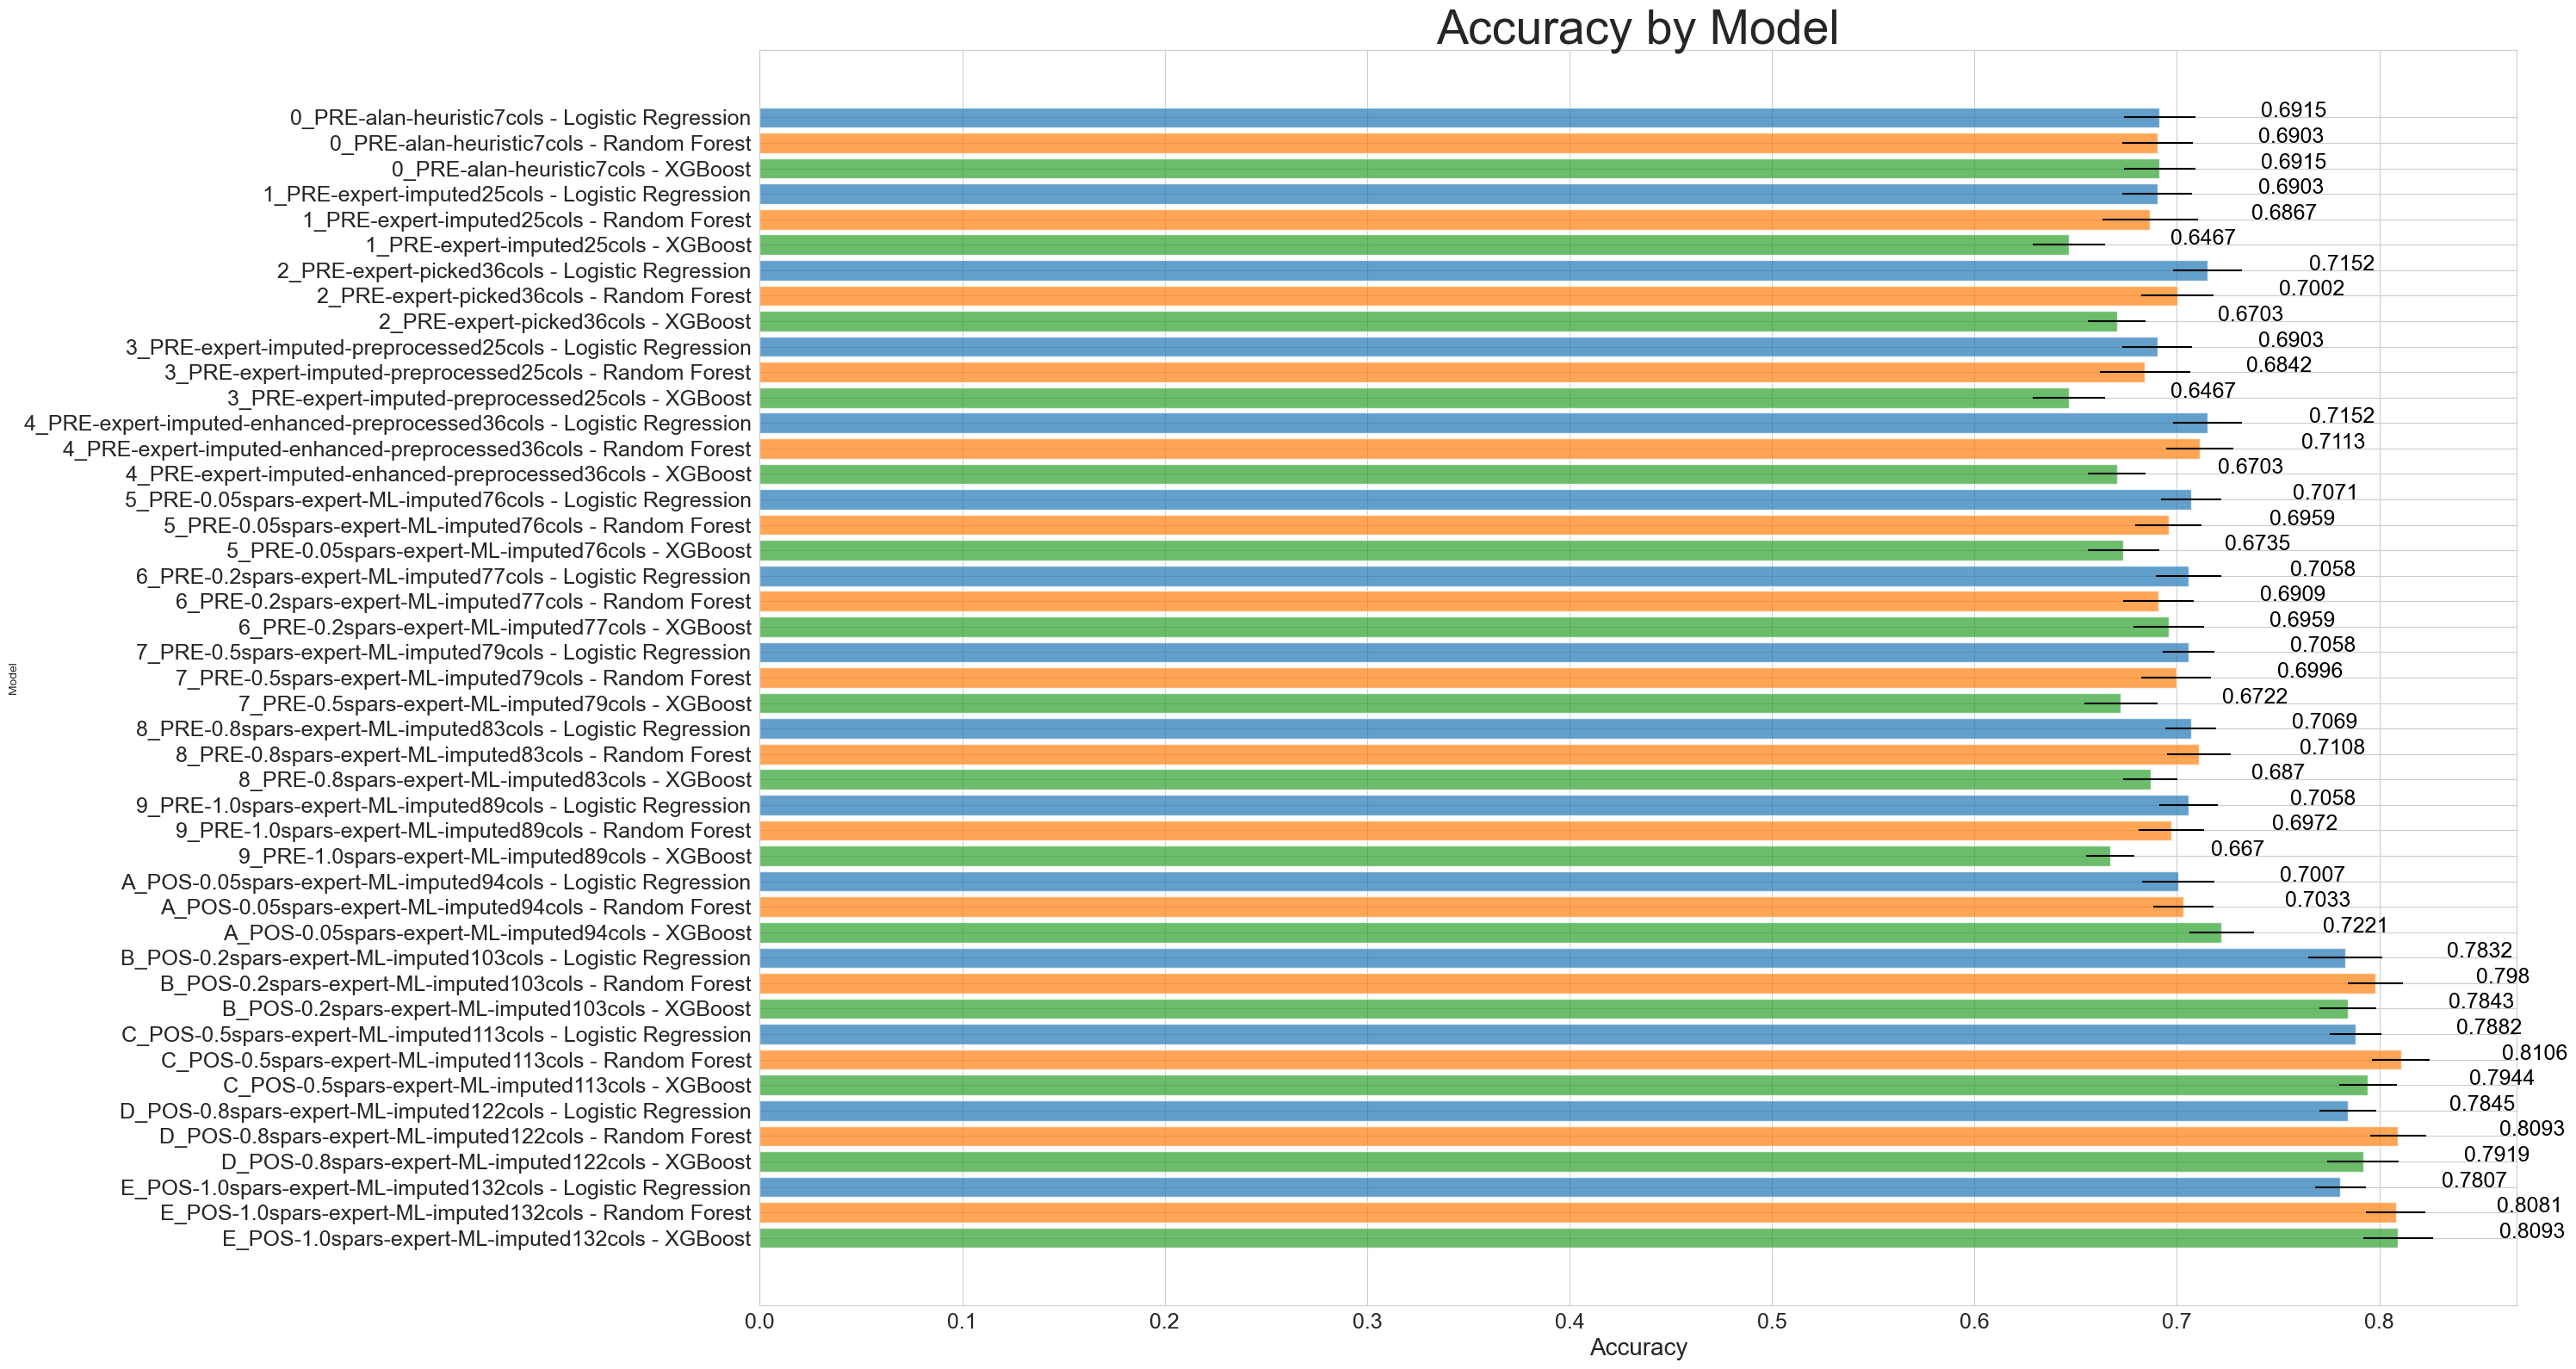

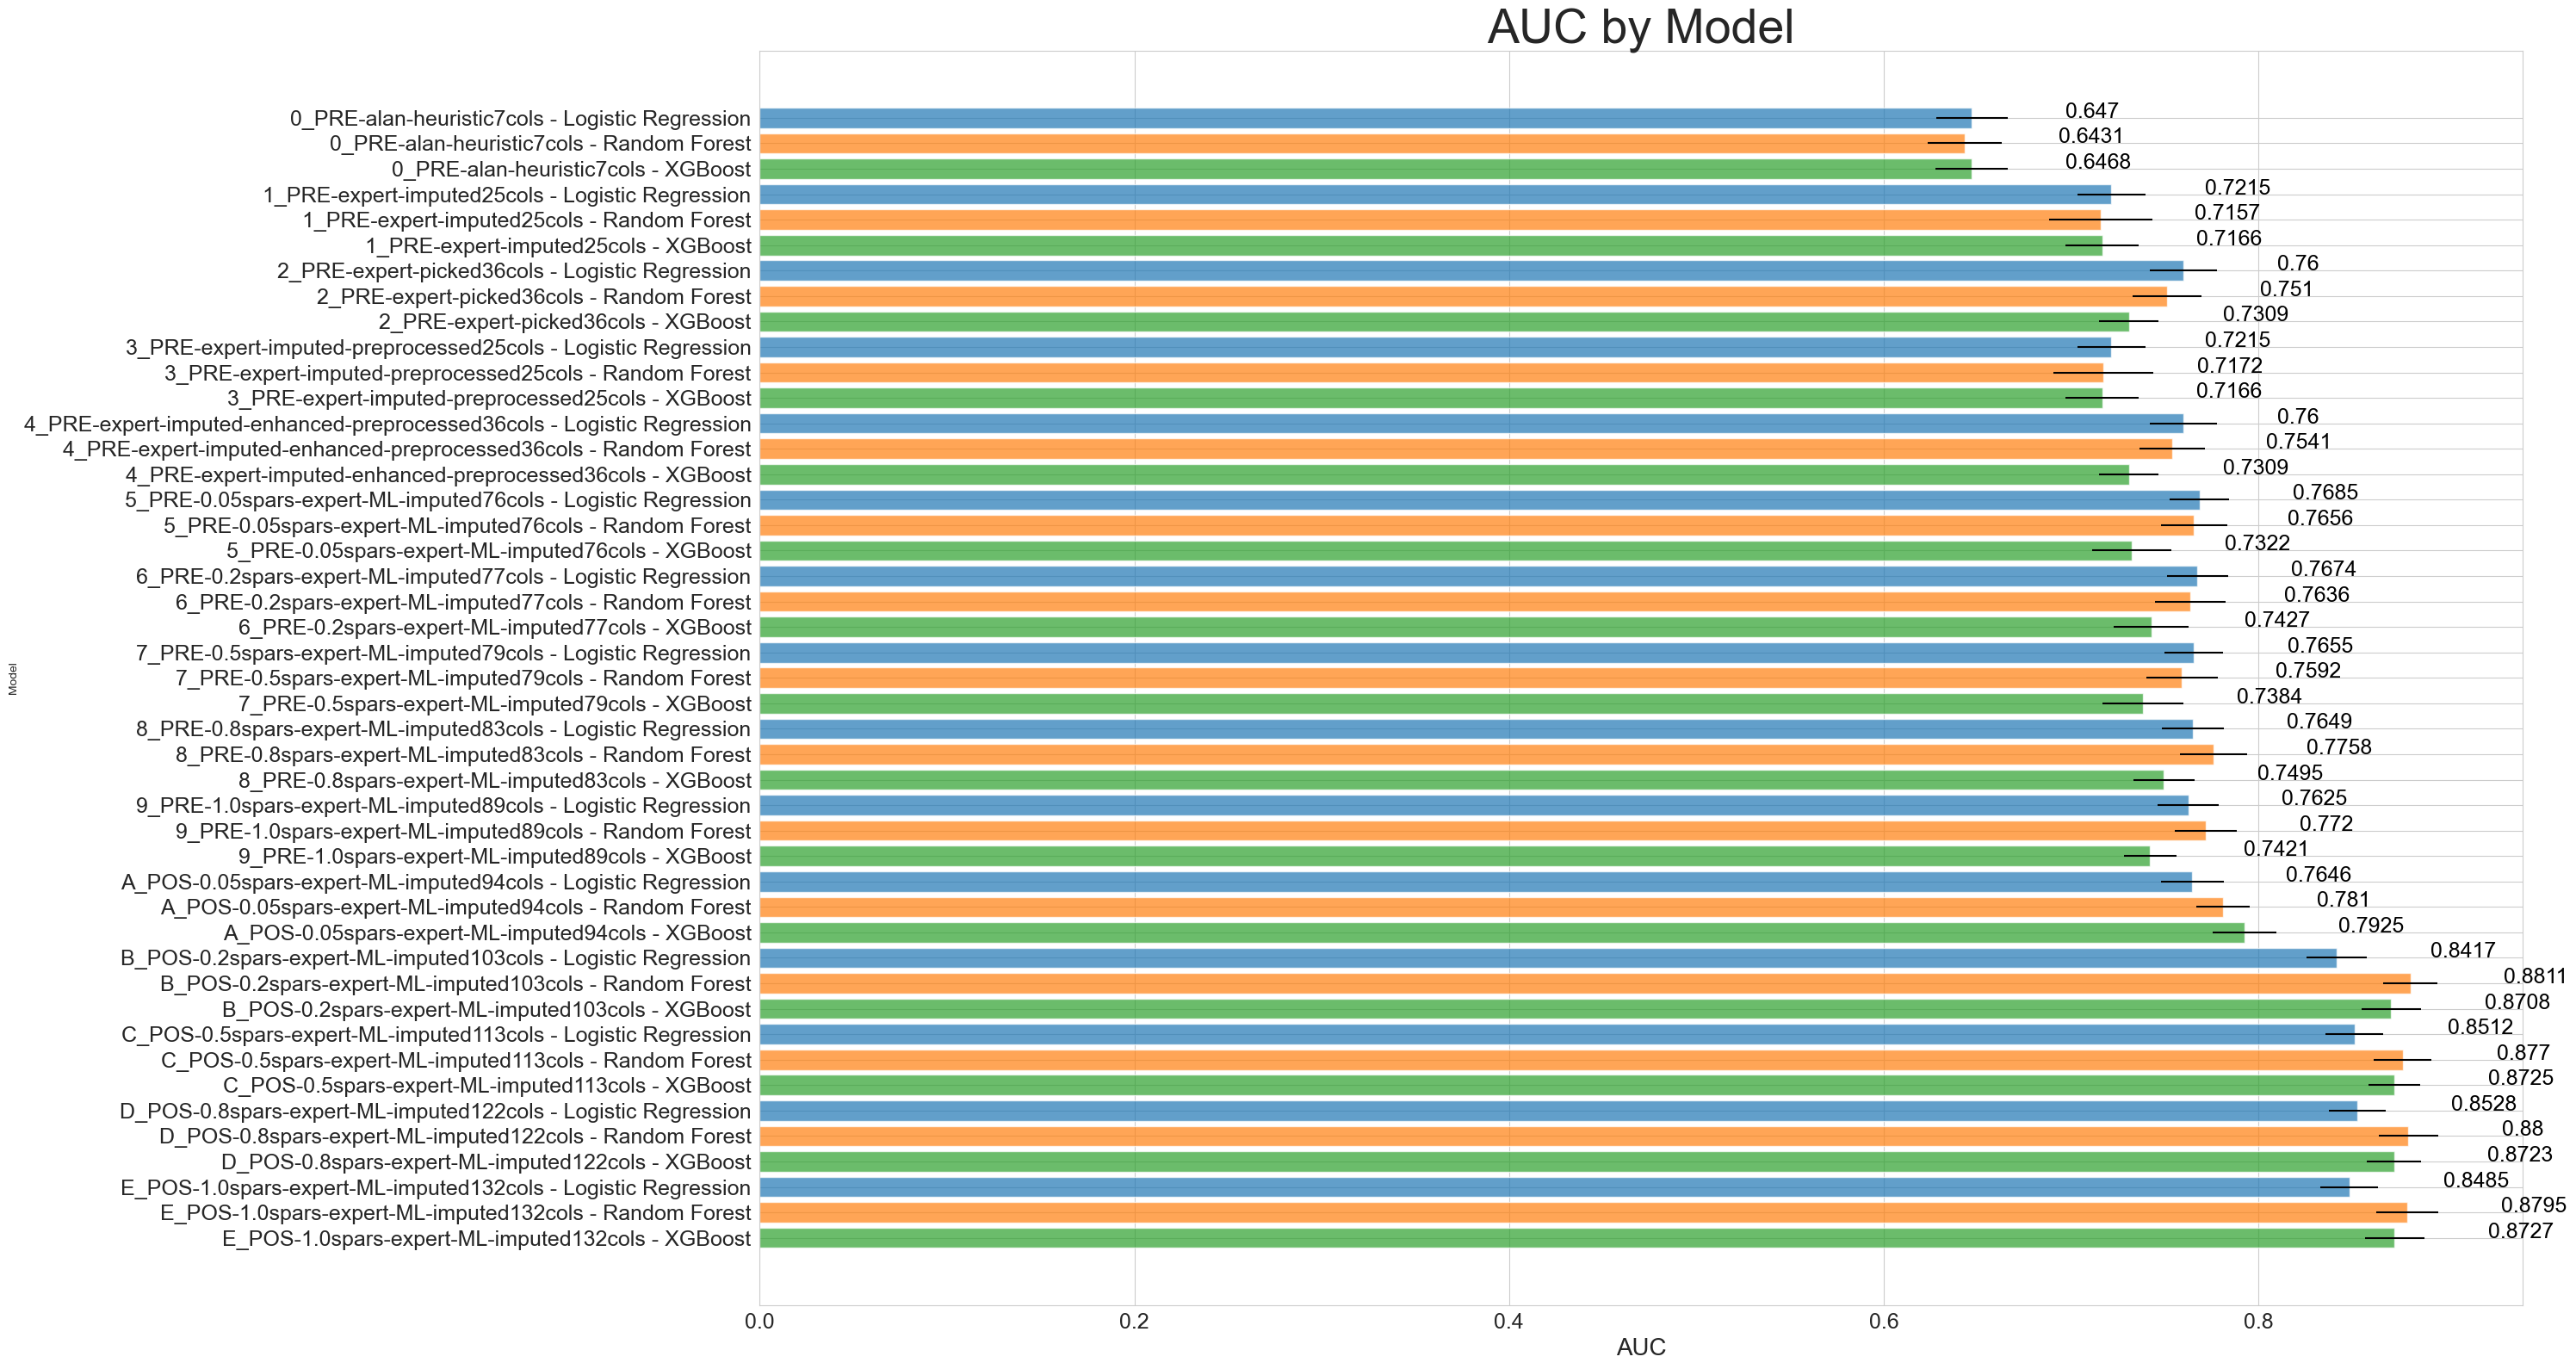

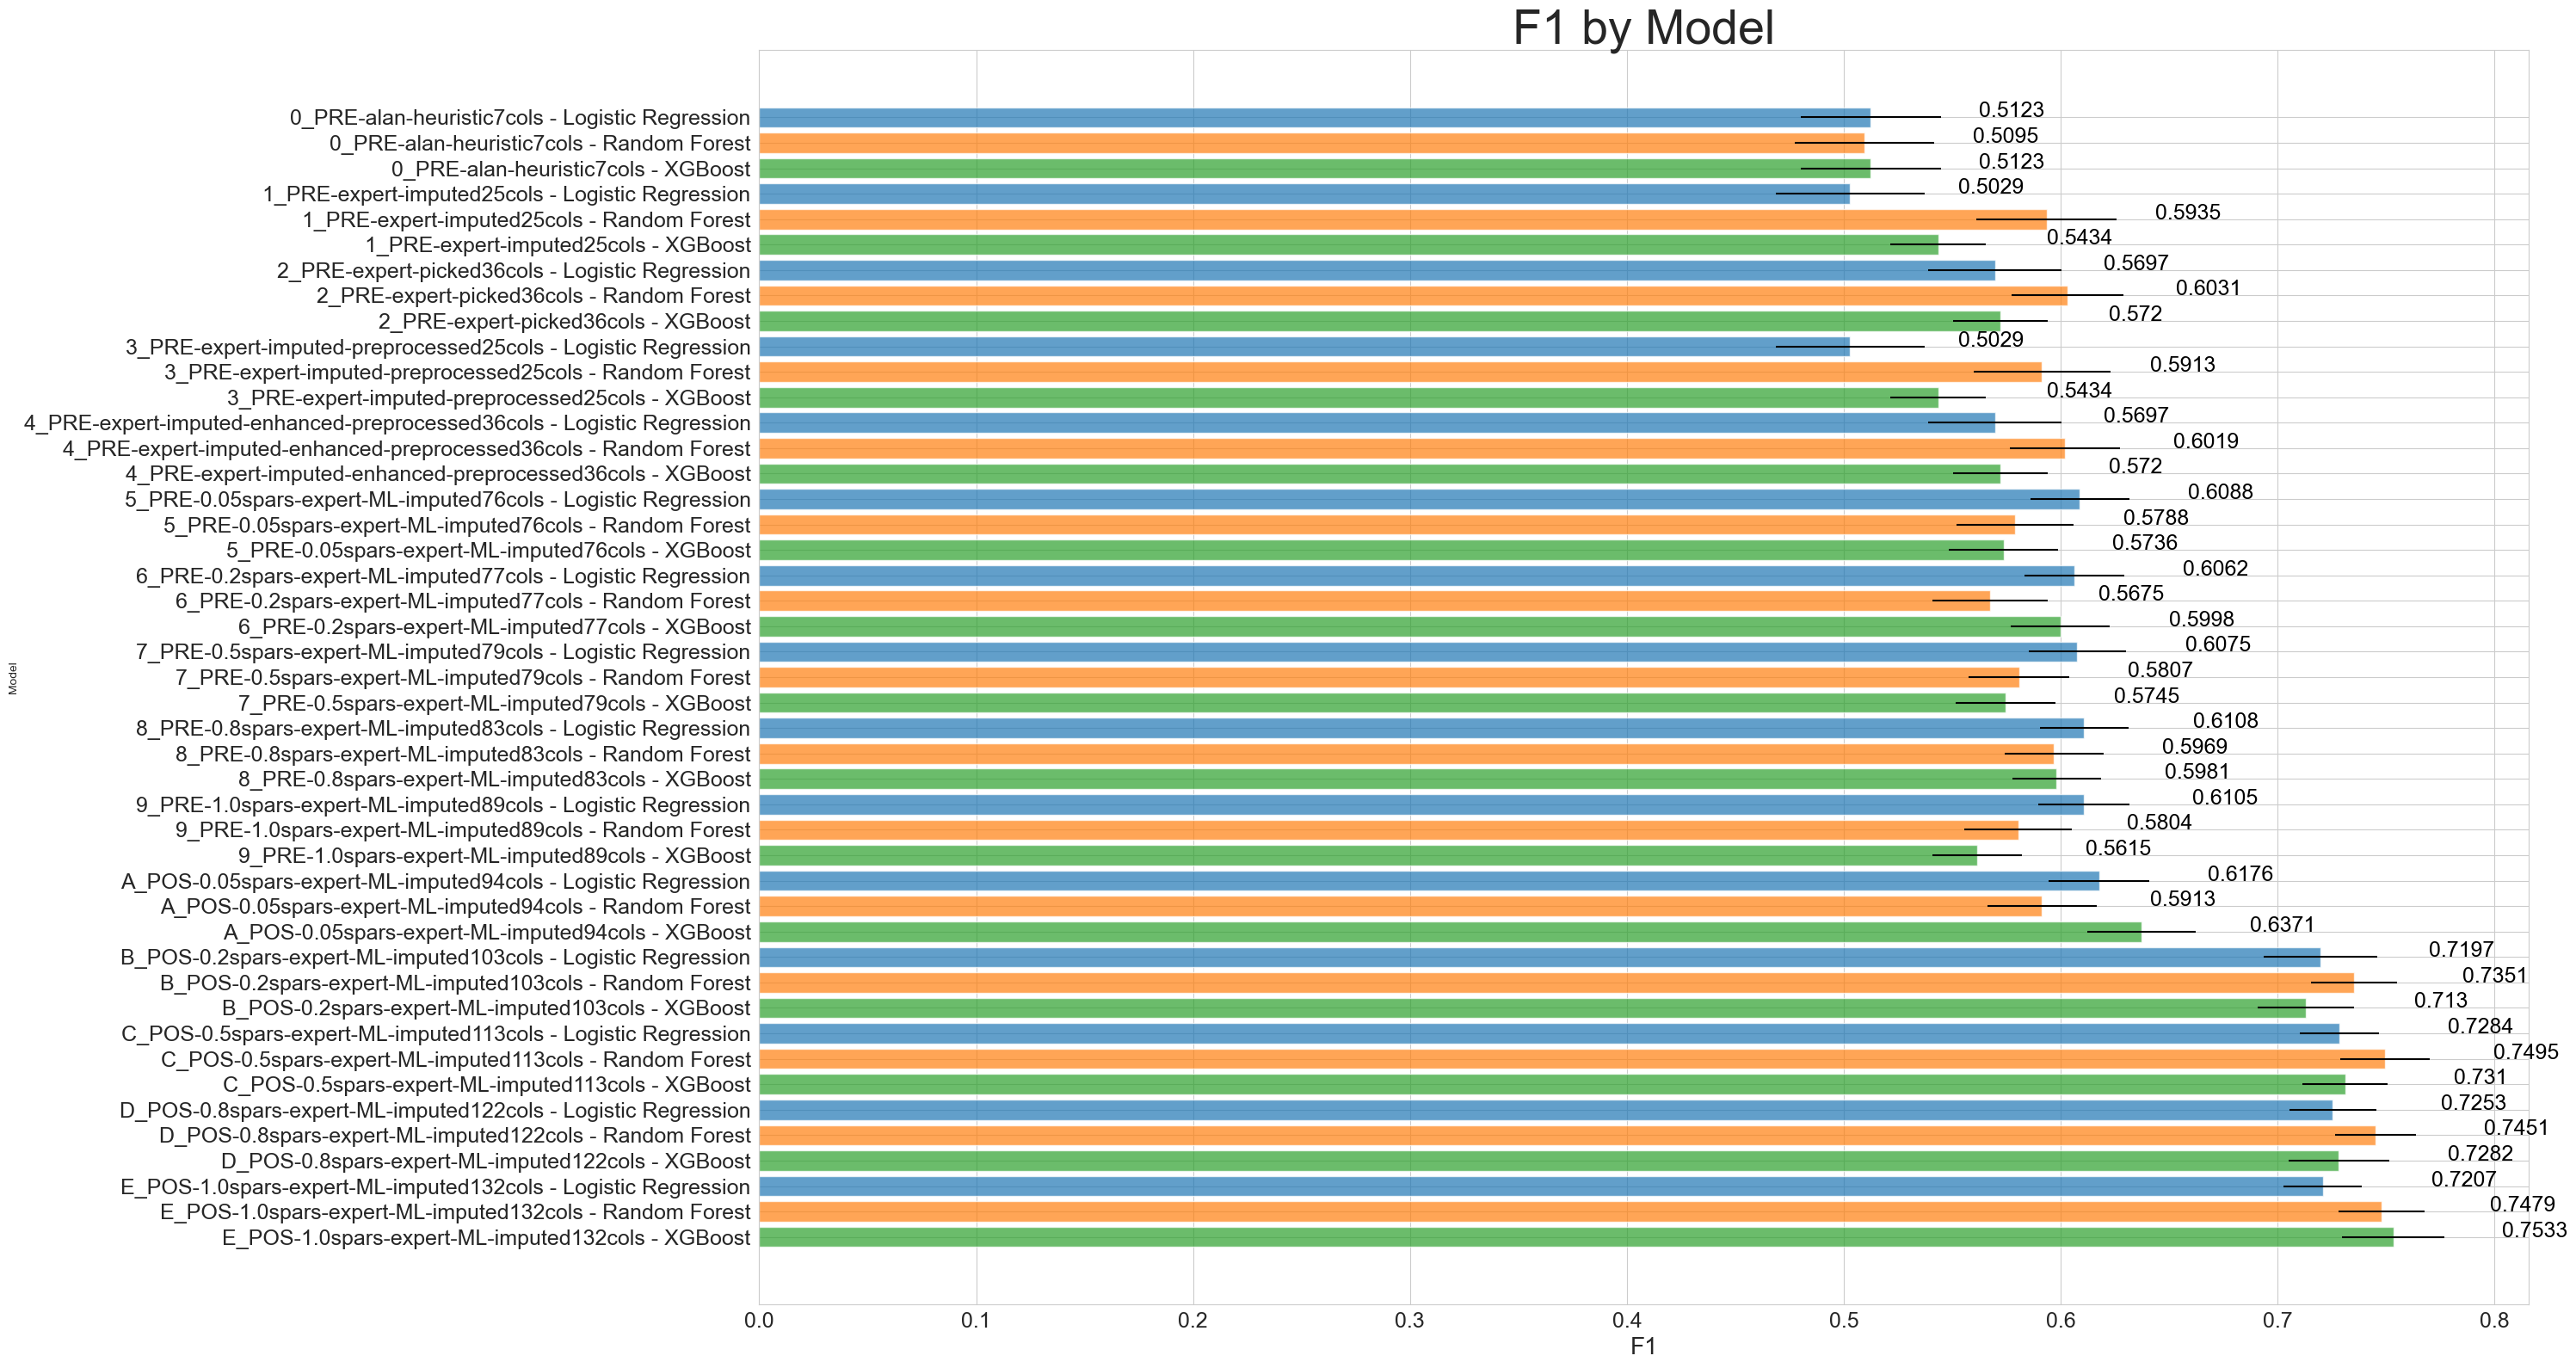

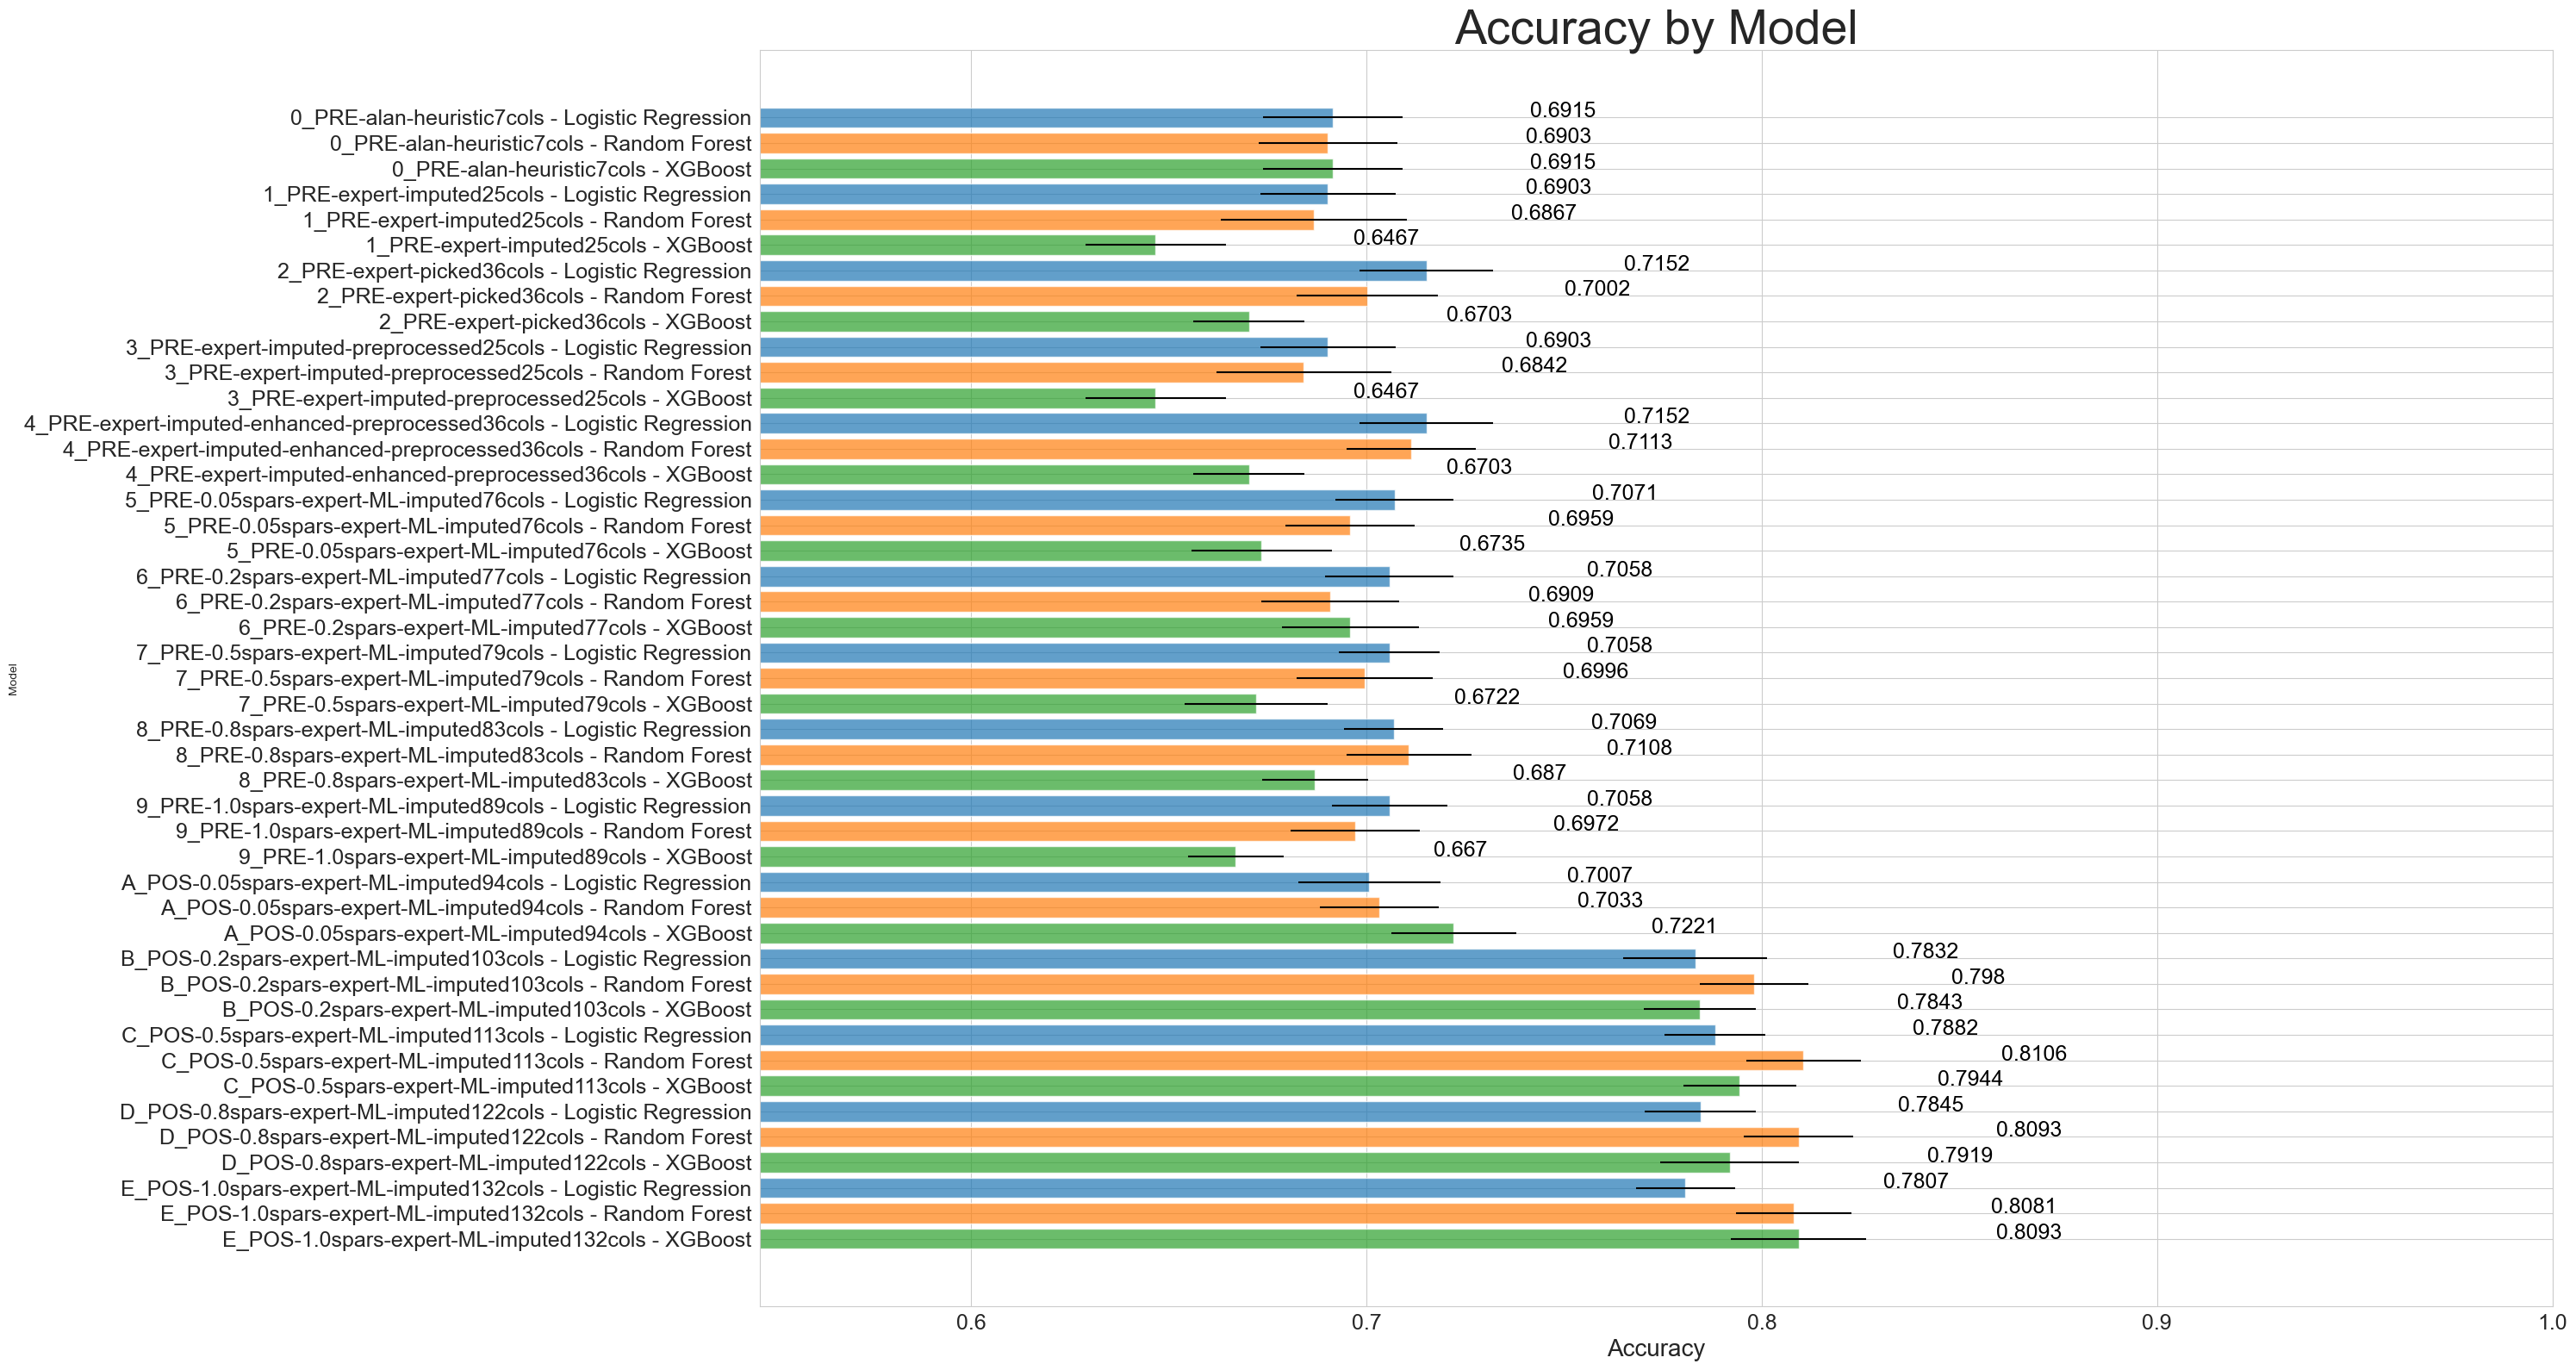

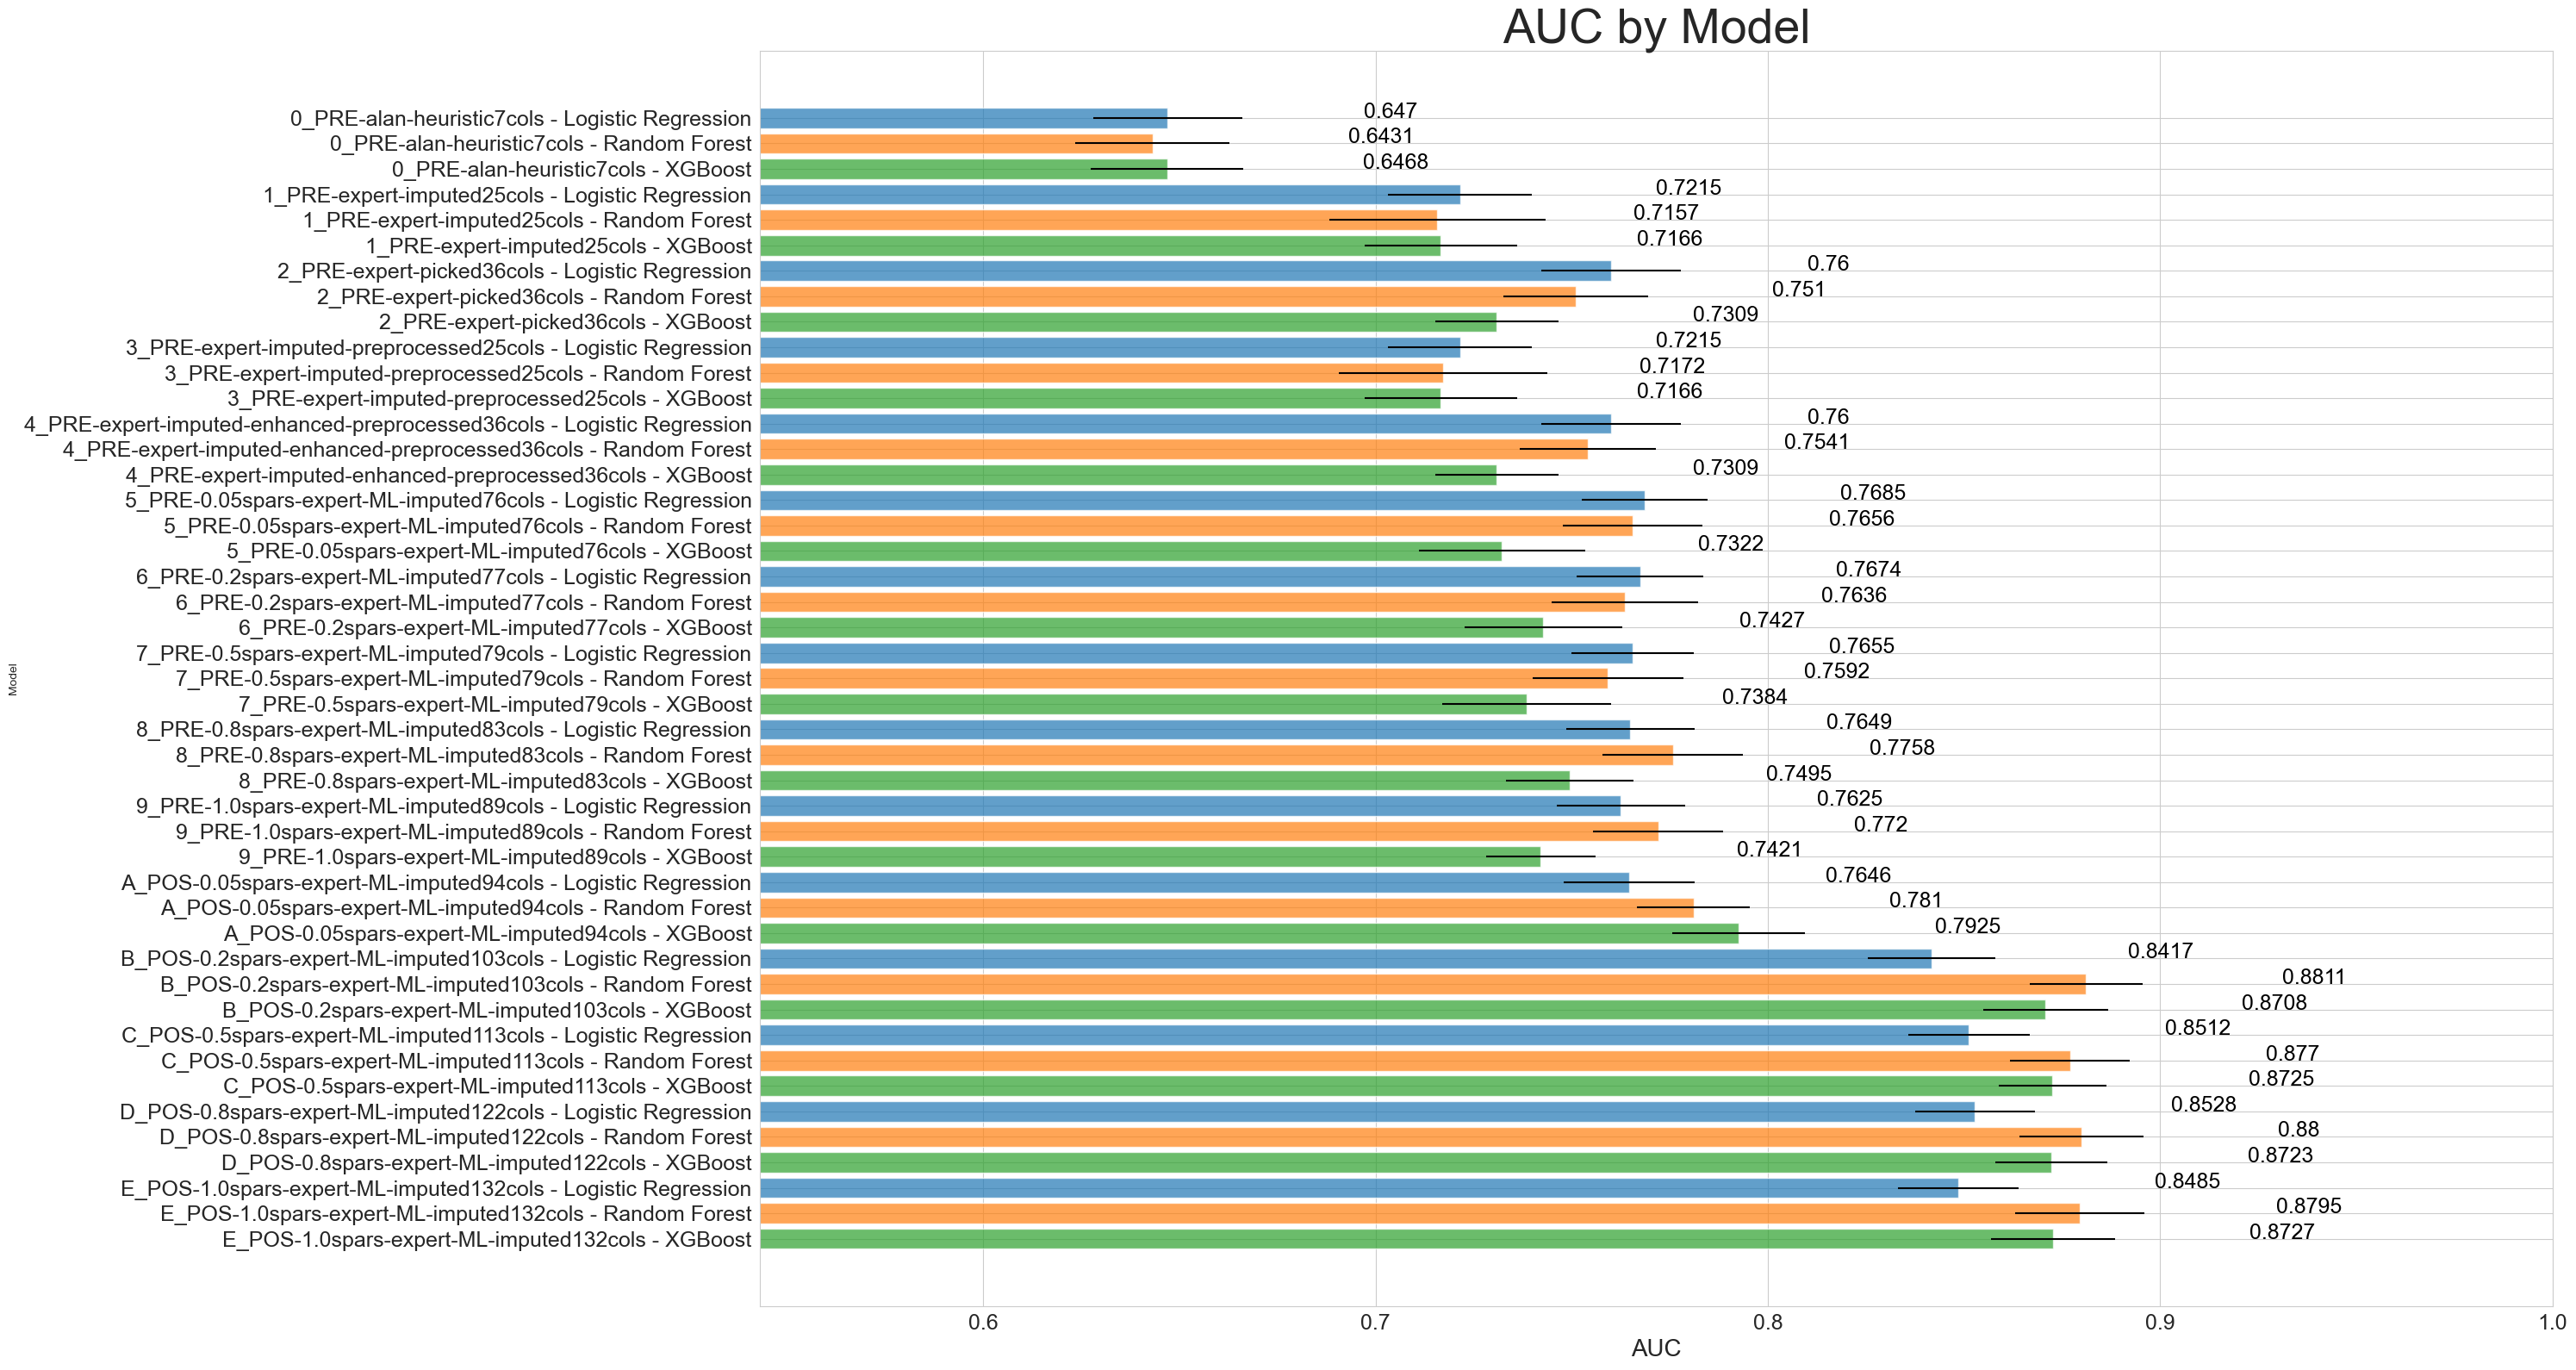

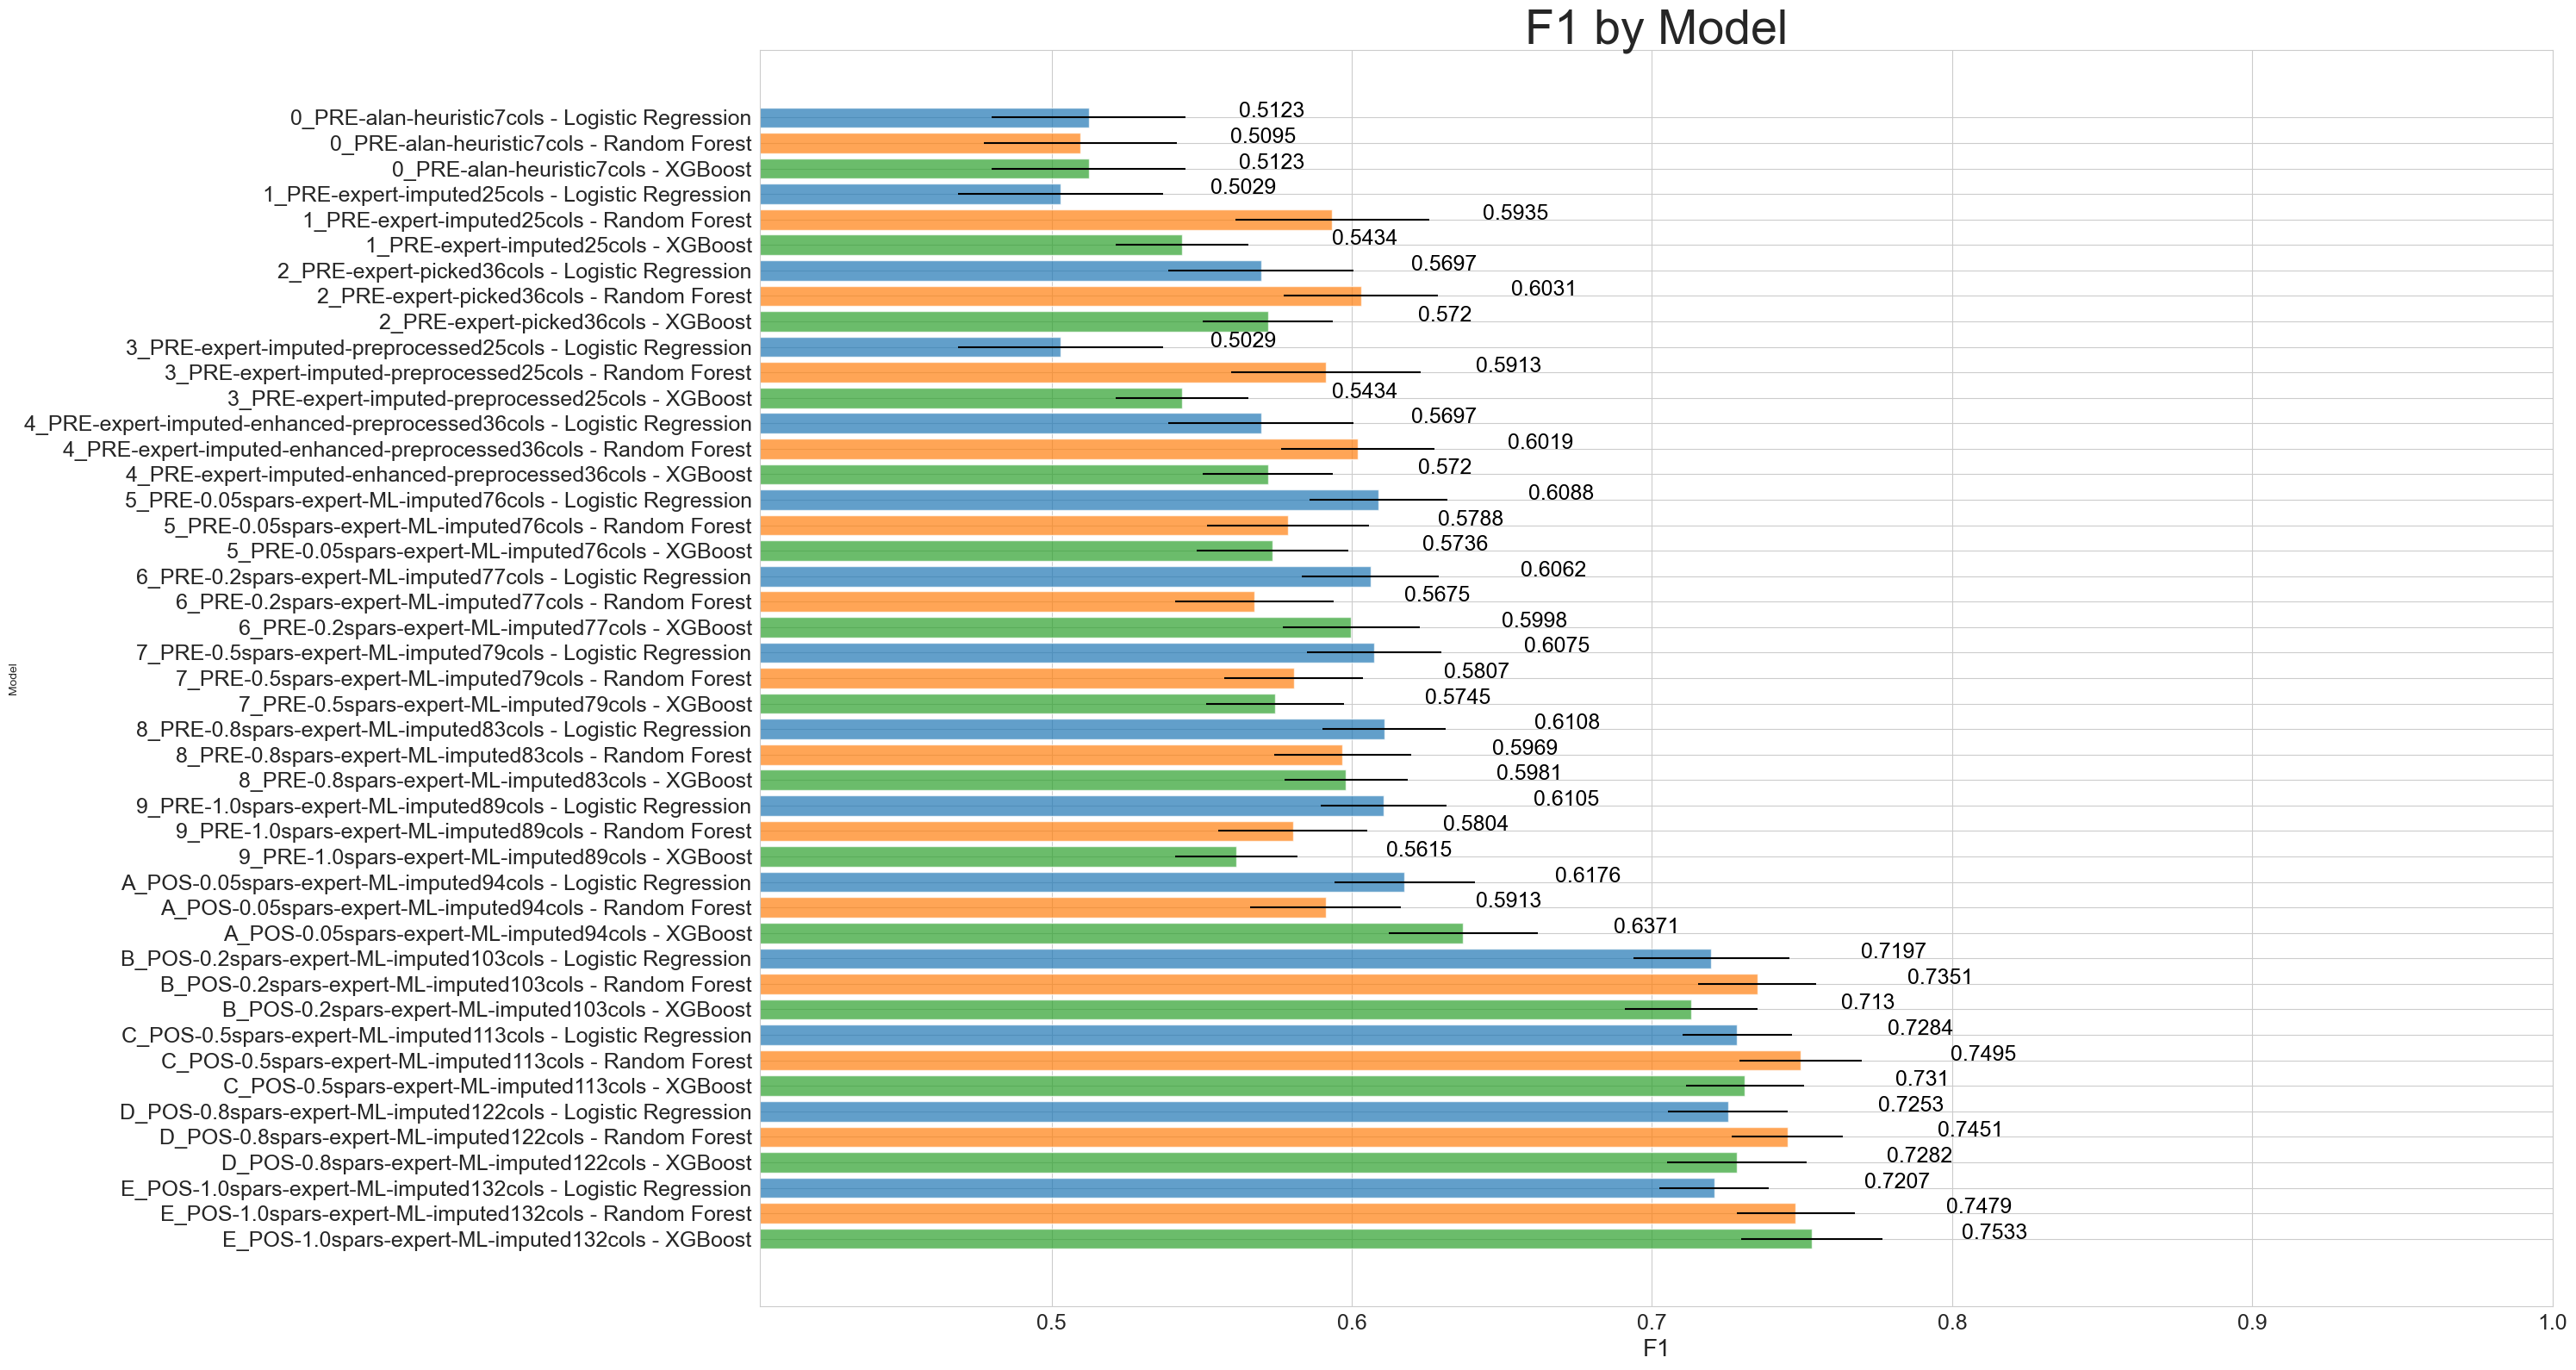

In [8]:
# Import plotting libraries for machine learning experiments
import matplotlib.pyplot as plt
import seaborn as sns



# Retrive the saved DataFrames, and plot the results
# Plot the results for each DataFrame on a single plot
# Reset plot parameters
plt.rcParams.update(plt.rcParamsDefault)
for use_broken_axis in [False, True]:
    for metric_name in ["Accuracy", "AUC", "F1"]:
        y_data = []
        errors = []
        x_data = []
        # Retrieve the performance for each model
        for df_name, print_df in plot_dict.items():
            # Iterate through the models of the DataFrame
            for i, row in print_df.iterrows():
                # If the model is the metric, add it to the list
                model_name = row["Model"]
                # Use regular expression to retrieve the metric and its standard error
                metric = row["Avg " + metric_name]
                error = row["SE " + metric_name]
                df_name = row["Dataset"]
                df_name = df_name.replace("/", "").replace(".csv", "")
                x_data.append(metric)
                y_data.append(df_name + " - " + model_name)
                errors.append(error)
        # Create the plot
        # The plot has spaces between the bars
        plt.figure(figsize=(30, 16))
        # Plot the gridlines
        sns.set_style("whitegrid")
        # The color of the bar should alternate between 3 colors
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
        # Make bars
        plt.barh(y_data, x_data, xerr=errors, color=colors, align="center", alpha=0.7)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        # Align the y-tick texts to the left
        ax = plt.gca()
        # for tick in ax.yaxis.get_majorticklabels():
        #     tick.set_horizontalalignment("left")
        # Set the labels on top of the bars
        for i, v in enumerate(x_data):
            plt.text(v + 0.05, y_data[i], str(v), color="black", fontsize=18)
        plt.gca().invert_yaxis()
        if use_broken_axis:
            # Set the range of the x-axis to be between the min - 0.1 and 1
            axis_start = min(x_data) - 0.1
            plt.xlim(axis_start, 1)

        plt.xlabel(metric_name, fontsize=20)
        plt.ylabel("Model")
        plt.title(f"{metric_name} by Model", fontsize=40)

        plt.tight_layout()
        if use_broken_axis:
            # Save the plot
            plt_name = f"{metric_name}_br_axis.png"
        else:
            plt_name = f"{metric_name}_full_axis.png"
        plt.savefig(os.path.join(plot_dir, plt_name))
        plt.show()
        plt.close()



In [9]:
# For each dataset in all_top_features, build a DataFrame with the top features
# The features for each model is ranked by their score
# The most important features shared by all models are sorted to the top
# Create a dictionary for holding the feature scores per dataset
# Schema: {"Dataset1": {"Model1": {"Feature_1": score_1, ...}, ...}, ...}
def tabularize_feature_ranks(all_top_features, model_names, merged_df_prefixes, top_k_percent=10, do_print=True):
    """Given a dictionary of top features, tabulate the feature ranks for each model

    Args:
        all_top_features (_type_): A dictionary of top features
        model_names (list, optional): Models for the merged table. Defaults to ["Random Forest"].
        merged_df_prefixes (list, optional): Prefixes for the merged dataset names, e.g., ["0", "1", ...]
        top_k_percent (int, optional): The top k percent of features to be counted in the final table. Defaults to 40.
        do_print (bool, optional): Whether to print the table. Defaults to True.

    """
    # Keep only the datasets that startswith prefixes in merged_df_prefixes
    # Create a copy of all_top_features
    all_top_features = copy.deepcopy(all_top_features)
    for df_name in list(all_top_features.keys()):
        if not any([df_name.startswith(prefix) for prefix in merged_df_prefixes]):
            del all_top_features[df_name]
    
    result_df_dict = OrderedDict()
    # Columns: Dataset1 Score, Dataset2 Score, ...
    # Rows: Feature1, Feature2, ...
    # We currently only consider the Random Forest model
    for dataset, model_dict in all_top_features.items():
        if do_print:
            print_and_log("-"*50)
            print_and_log(f"Processing {dataset}...")
            # Print the number of features for this dataset
            print_and_log(f"Number of features: {len(model_dict['Random Forest'])}")
        LR_features = model_dict["Logistic Regression"]
        RF_features = model_dict["Random Forest"]
        XGB_features = model_dict["XGBoost"]
        # Sort the features by their scores
        sorted_LR_features = sorted(LR_features.items(), key=lambda x: x[1], reverse=True)
        sorted_RF_features = sorted(RF_features.items(), key=lambda x: x[1], reverse=True)
        sorted_XGB_features = sorted(XGB_features.items(), key=lambda x: x[1], reverse=True)

        # Convert each score into a rank
        rank_LR_features = {feat: i+1 for i, (feat, score) in enumerate(sorted_LR_features)}
        rank_RF_features = {feat: i+1 for i, (feat, score) in enumerate(sorted_RF_features)}
        rank_XGB_features = {feat: i+1 for i, (feat, score) in enumerate(sorted_XGB_features)}
        # Assert all the features are present in the sorted features dictionary
        assert set(rank_LR_features.keys()) == set(rank_RF_features.keys()) == set(rank_XGB_features.keys())
        # Create a DataFrame with all the features
        df = pd.DataFrame({"Features": list(rank_LR_features.keys())})
        # Calculate the feature scores for each model
        # Add the ranks of RF to the DataFrame
        df["RF_rank"] = df["Features"].map(rank_RF_features)
        # Add the ranks of LR to the DataFrame
        df["LR_rank"] = df["Features"].map(rank_LR_features)
        # Add the ranks of XGB to the DataFrame
        df["XGB_rank"] = df["Features"].map(rank_XGB_features)
        # Add the raw scores of RF to the DataFrame
        df["RF_score"] = df["Features"].map(RF_features)
        # Add the raw scores of LR to the DataFrame
        df["LR_score"] = df["Features"].map(LR_features)
        # Add the raw scores of XGB to the DataFrame
        df["XGB_score"] = df["Features"].map(XGB_features)
        # Add a column corresponding to the overall ranking using Rank Product Statistic (geometric mean of the ranks)
        df["Rank_Product^(1/3)"] = (df["RF_rank"] * df["LR_rank"] * df["XGB_rank"]) ** (1/3)
        # Sort the DataFrame by the ranks of the features
        df = df.sort_values(by="RF_rank")
        df_rank_product = df.sort_values(by="Rank_Product^(1/3)")
        # Reset the index
        df = df.reset_index(drop=True)
        # Add Rank_Product_Rank column, where the rank is the index of the row in df_rank_product
        product_rank_map = {feat: i+1 for i, feat in enumerate(df_rank_product["Features"])}
        df["Rank_Product_Rank"] =  df["Features"].map(product_rank_map)
        
        # Keep only the top 1/3 of features (the most important features)
        # df = df.iloc[:len(df)//3]
        # Round all the entries to 2 decimal places
        df = df.round(2)
        result_df_dict[dataset] = df
        # Print the DataFrame, ignoring the index
        if do_print:
            print_and_log(df.to_string(index=False))
    
    # # Keep only the datasets that startswith prefixes in merged_df_prefixes
    # result_df_dict = {k: v for k, v in result_df_dict.items() if k.startswith(tuple(merged_df_prefixes))}
    
    # Get all the features from the feature importance 
    all_features = set()
    for dataset, df in result_df_dict.items():
        all_features.update(df["Features"].values)


    # Merge the DataFrames for each dataset
    # The rows are the features, the columns are the datasets
    # The values are the Random Forest and Logistic Regression scores of the features in each dataset
    merged_df = pd.DataFrame({"Features": list(all_features)})
    # Merge feature scores
    for dataset_name, df in result_df_dict.items():
        dataset_name = dataset_name.replace("expert", "").replace("imputed", "")
        dataset_name = re.sub("-{2,}", "-", dataset_name)
        # Keep only the columns RF_score and LR_score
        for model_name in model_names:
            col_name = model_name + "_" + dataset_name
            feat_to_score_dict = {feat: df[df["Features"] == feat][model_name + "_score"].values[0] for feat in df["Features"]}
            mean_feature_score = np.mean(list(feat_to_score_dict.values()))
            for i, row in merged_df.iterrows():
                feat = row["Features"]
                if feat in feat_to_score_dict:
                    merged_df.loc[i, col_name] = feat_to_score_dict[feat]
                else:
                    merged_df.loc[i, col_name] = np.nan
    # Create a column that counts the frequency of the feature score being among the top features
    # For each col in rf_score_cols, and each feature, calculate the frequency of the feature score being among the top K% in this col
    top_k_freq_dict = defaultdict(lambda: defaultdict(int))
    # Schema: {model_name: {feature: int}}
    for dataset_name, df in result_df_dict.items():
        df_sorted = df.sort_values(by="RF_rank")
        dataset_name = dataset_name.replace("expert", "").replace("imputed", "")
        dataset_name = re.sub("-{2,}", "-", dataset_name)
        for model_name in model_names:
            col_name = model_name + "_" + dataset_name
            for i, row in merged_df.iterrows():
                feat = row["Features"]
                feat_score = row[col_name]
                is_top_k = 0
                if feat_score in df_sorted.iloc[:max(1, int(len(df)*top_k_percent)//100)][model_name+"_score"].values:
                    is_top_k = 1
                top_k_freq_dict[model_name][feat] += is_top_k
                # if feat == "PRE_age_at_dx" and is_top_k:
                #     print(f"age_at_dx score: {feat_score} in top K of {dataset_name} {model_name}")
                # raise ValueError("Fix this problem, not sure why LR isn't counted correctly")
    
    # Insert Top_K%_Freq columns after "Features" column
    for i, model_name in enumerate(model_names):
        merged_df.insert(
            i+1, model_name+ f"_Top_{top_k_percent}%_Freq",
            merged_df["Features"].map(top_k_freq_dict[model_name])
            )

    # Insert _Top_Probability columns
    # Where the value is the probability it's top-K% vs the number of times the feature occurred in dataset
    num_feature_occurred = defaultdict(int)
    for df_name, model_dict in all_top_features.items():
        for model, feat_dict in model_dict.items():
            for feat in feat_dict.keys():
                num_feature_occurred[feat] += 1
            break
    
    for i, model_name in enumerate(model_names):
        merged_df.insert(
            i+1, model_name+f"_Top_{top_k_percent}%_Prob",
            merged_df["Features"].map(lambda feat: top_k_freq_dict[model_name][feat]/num_feature_occurred[feat] if feat in feat_dict else 0)
            )
    # Sort the DataFrame by Top_K%_Probability
    merged_df = merged_df.sort_values(
        by=[model_name + f"_Top_{top_k_percent}%_Prob" for model_name in model_names] + \
           [model_name + f"_Top_{top_k_percent}%_Freq" for model_name in model_names],
        ascending=False)

    # Cleaning up the merged_df
    # Round all the entries to 2 decimal places
    merged_df = merged_df.round(2)
    # Remove rows with NaN in all except the column "Features", i.e. the feature was not used by any model
    merged_df = merged_df.dropna(how="all", subset=merged_df.columns[1:])
    
    print_and_log(f"Total number of features: {len(merged_df)}")

    # Save the merged DataFrame
    merged_df_path = os.path.join(plot_dir, f"merged_feature_scores_datasets{''.join(merged_df_prefixes)}.csv")
    merged_df.to_csv(merged_df_path, index=False)
    print_and_log(f"Merged DataFrame saved to {merged_df_path}")
    return merged_df, top_k_freq_dict

df_merged, top_k_freq_dict = tabularize_feature_ranks(
    all_top_features,
    model_names=["RF", "LR"],
    merged_df_prefixes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
    do_print=False
)

df_merged, top_k_freq_dict = tabularize_feature_ranks(
    all_top_features,
    model_names=["RF", "LR"],
    merged_df_prefixes=[df_name[0] for df_name in all_top_features.keys()],
    do_print=False
)
# print_and_log(df_merged.to_string(index=False))

Total number of features: 85
Merged DataFrame saved to /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/output/2022-07-13-133052_without_imputation/DataFrames/subset_dataframes/plots/merged_feature_scores_datasets0123456789.csv
Total number of features: 127
Merged DataFrame saved to /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/output/2022-07-13-133052_without_imputation/DataFrames/subset_dataframes/plots/merged_feature_scores_datasets0123456789ABCDE.csv


Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-0 features out of 84. This feature is random noise baseline.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... Fold 6... Fold 7... Fold 8... Fold 9... Fold 10... Fold 11... Fold 12... Fold 13... Fold 14... Fold 15... Fold 16... Fold 17... Fold 18... Fold 19... Fold 20... Fold 21... Fold 22... Fold 23... Fold 24... Fold 25... Fold 26... Fold 27... Fold 28... Fold 29... Fold 30... Fold 31... Fold 32... Fold 33... Fold 34... Fold 35... Fold 36... Fold 37... Fold 38... Fold 39... Fold 40... Fold 41... Fold 42... Fold 43... Fold 44... Fold 45... Fold 46... Fold 47... Fold 48... Fold 49... Fold 50... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.5948      0.0043  0.5298  0.0266     0.0     0.0
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.5289      0.0176  0.5147  0.0229  0.400

<Figure size 640x480 with 0 Axes>

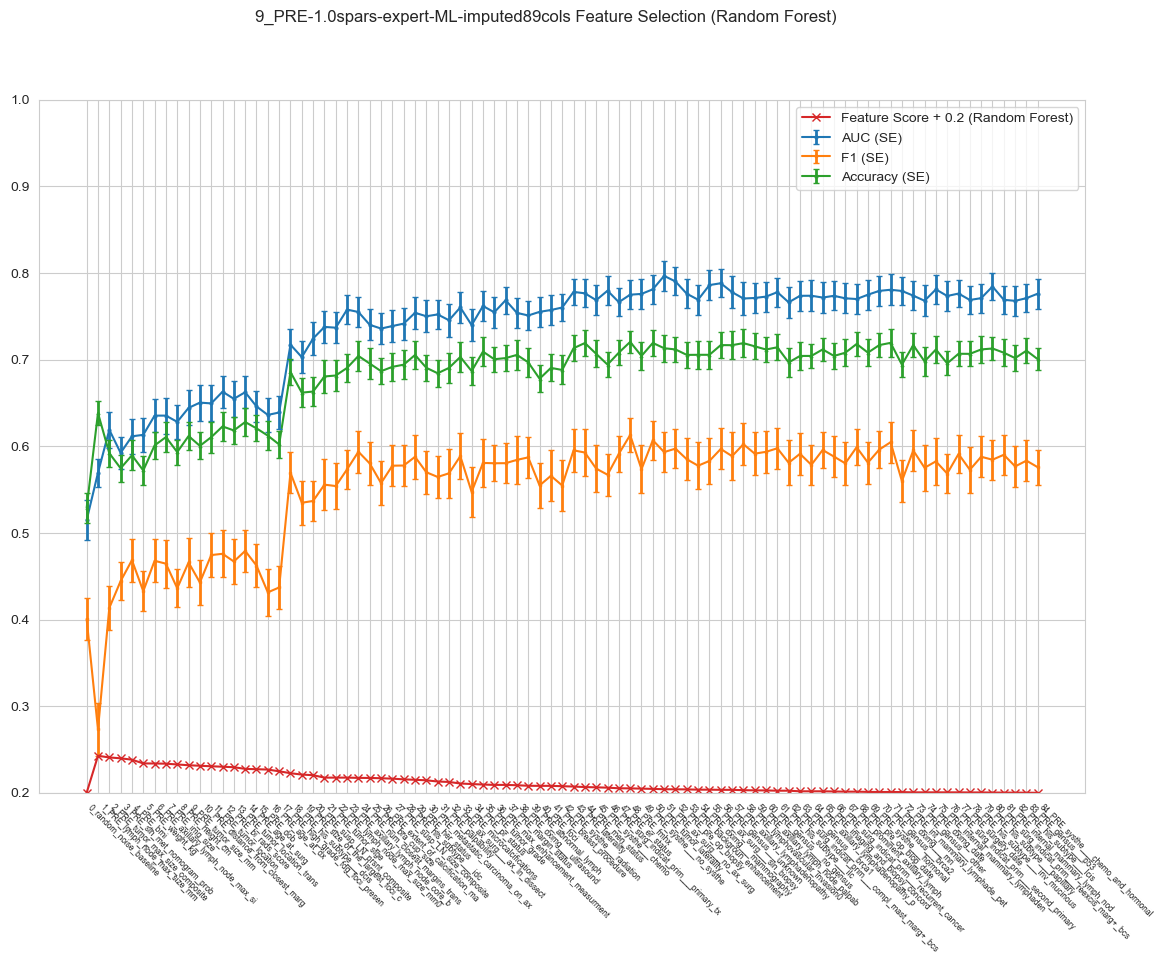

Processing E_POS-1.0spars-expert-ML-imputed132cols with top-0 features out of 126. This feature is random noise baseline.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... Fold 6... Fold 7... Fold 8... Fold 9... Fold 10... Fold 11... Fold 12... Fold 13... Fold 14... Fold 15... Fold 16... Fold 17... Fold 18... Fold 19... Fold 20... Fold 21... Fold 22... Fold 23... Fold 24... Fold 25... Fold 26... Fold 27... Fold 28... Fold 29... Fold 30... Fold 31... Fold 32... Fold 33... Fold 34... Fold 35... Fold 36... Fold 37... Fold 38... Fold 39... Fold 40... Fold 41... Fold 42... Fold 43... Fold 44... Fold 45... Fold 46... Fold 47... Fold 48... Fold 49... Fold 50... 
                                Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
E_POS-1.0spars-expert-ML-imputed132cols Logistic Regression       0.5948      0.0043  0.5172  0.0221     0.0     0.0
E_POS-1.0spars-expert-ML-imputed132cols       Random Forest       0.5399        0.02  0.5173  0.0221  

<Figure size 640x480 with 0 Axes>

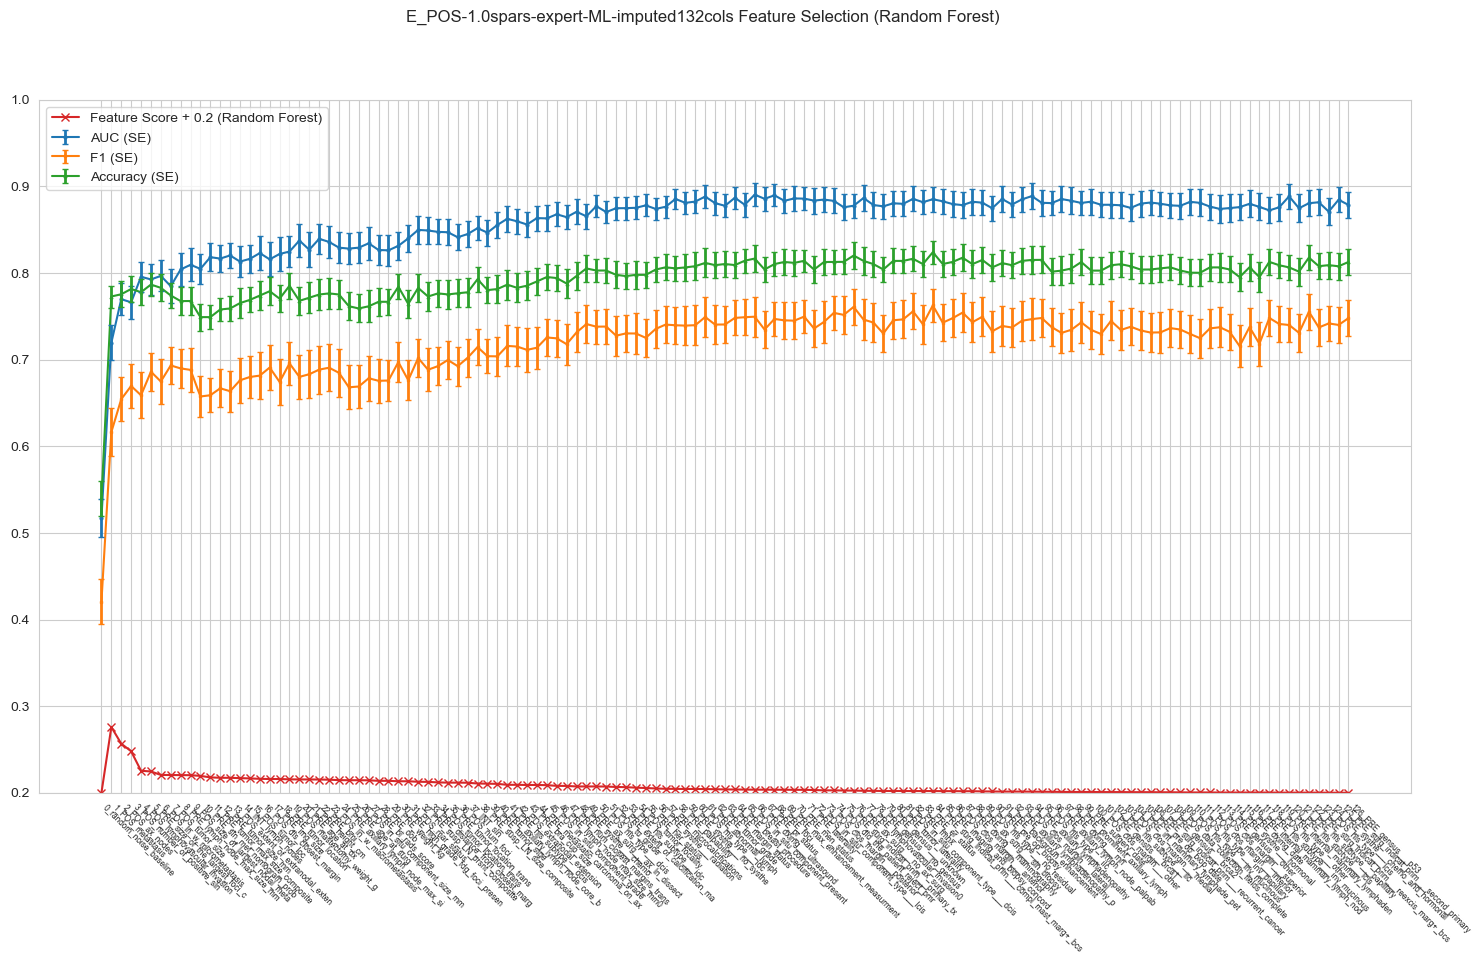

In [10]:
# Conduct experiments for determining the cumulative effect of the features on the model performance
# For each dataset, train the models on the top-1 most important feature, then top-2, top-3, ...
# Save the results of each experiment in a dictionary
# Import sleep module to allow the program to pause for a few seconds
import time
# def ... TODO: wrap the following code into a neat, reusable function
num_folds = 50
model_name = "Random Forest"
target_column = "POS_did_the_patient_receive_pm"
metrics_df = pd.DataFrame(columns=metrics_df_columns)
# Create a dictionary for holding the DataFrames for plotting
# Schema: {"Dataset1": {"Top1_feature": metrics_df1, "Top2_feature": metrics_df2, ...}, ...}
plot_dict2 = defaultdict(OrderedDict)
# Re-use the all_top_features dictionary for deciding the order of the features to use

def plot_num_features_vs_metrics(all_top_features, model_name, target_column, metrics_df, plot_dict2, plot_dir):
    
    for df_name in all_top_features:
        if not ("1.0" in df_name):
            continue
        # Create a DataFrame for the top-k most important feature
        # Sort all features by feature scores
        all_features_sorted = [f[0] for f in sorted(all_top_features[df_name][model_name].items(), key=lambda x: x[1], reverse=True)]
        num_features = len(all_features_sorted)
        df_all_features = dfs_std[df_name]
        for k in range(0, num_features+1):
            if k == 0:
                # Random noise baseline
                top_k_features = "random_noise_baseline"
                print_and_log(f"Processing {df_name} with top-{k} features out of {num_features}. This feature is random noise baseline.")
                df_top_k_features = df_all_features[[target_column]]
                noise_data = np.random.rand(len(df_top_k_features))
                df_top_k_features.insert(0, "0_random_noise_baseline", noise_data)
                assert len(df_top_k_features.columns) == 2
            else:
                # Get the top-k most important features
                top_k_features = all_features_sorted[:k]
                print_and_log(f"Processing {df_name} with top-{k} features out of {num_features}. The k-th is {top_k_features[-1]}")
                # Create a DataFrame for the top-k most important features, and the target variable
                df_top_k_features = df_all_features[top_k_features + [target_column]]
                assert len(df_top_k_features.columns) == k + 1
            metrics_df, feature_scores = build_classifiers(df_top_k_features, df_name, num_folds=num_folds)
            # print metrics_df, without index
            print_and_log("")
            print_and_log(metrics_df.to_string(index=False, justify="right"))
            print_and_log("-"*30)
            # Add the DataFrame to the dictionary for plotting later
            plot_dict2[df_name][k] = metrics_df
            # Sleep for a few seconds to cool down the hardware
            time.sleep(3)
        print("="*150)
        # Plot the metrics on the top-k most important features
        # The X-axis is the number of features, with the kth feature as label
        # The Y-axis is the metrics, with three types of metrics shown in separate markers
        # The Y-axis also shows the metric scores for each feature
        # The metrics are AUC, F1, and Accuracy, which are saved in metrics_df
        # The legend is the type of the metric
        # Use tight layout
        plt.tight_layout()
        fig, ax = plt.subplots()
        # Set the title of the figure
        fig.suptitle(f"{df_name} Feature Selection ({model_name})")
        marker_map = {"AUC": "o", "F1": "s", "Accuracy": "^"}
        for metric_name in ["AUC", "F1", "Accuracy"]:
            # Create figure
            plt_name = f"{df_name}_top_features_metrics.png"
            x_data = [i for i in range(1, num_features+1)]
            # Append the feature name to each x_data
            x_data = ["0_random_noise_baseline"] + [f"{i}_{all_features_sorted[i-1]}" for i in x_data]
            model_idx = metrics_df["Model"].values.tolist().index(model_name)
            y_data = []
            y_err = []
            for metrics_df in plot_dict2[df_name].values():
                # Get the data for plotting
                y_data.append(metrics_df["Avg " + metric_name].values[model_idx])
                y_err.append(metrics_df["SE " + metric_name].values[model_idx])
            # Plot the data
            ax.errorbar(
                x_data,
                y_data,
                yerr=y_err,
                marker=marker_map[metric_name],
                label=metric_name + " (SE)",
                ms=2,
                capsize=2,
                barsabove=True,
                elinewidth=2
            )
            # Rotate the x-axis labels
        # Add feature scores
        y_data = [0]
        for feature, score in sorted(all_top_features[df_name][model_name].items(), key=lambda x: x[1], reverse=True):
            y_data.append(score)
        # Add 0.2 to y_data to make the plot look better
        y_data = [y + 0.2 for y in y_data]
        ax.plot(x_data, y_data, marker="x", label=f"Feature Score + 0.2 ({model_name})")
        # Set the marker size to smaller sizes so error bars can be seen
        # Make the x-axis labels smaller if len_x_data is too long
        x_tick_size = 10 if len(x_data) < 30 else 6
        plt.xticks(rotation=-45, ha="left", size=x_tick_size)
        # Add legend
        ax.legend(loc="best")
        # Enforce the range of the y-axis
        ax.set_ylim(0.2, 1.0)
        fig.set_size_inches(len(x_data) * 0.1 + 5, 9)
        # Show major gridlines
        ax.grid(True, which="major", linestyle="-")
        # Show minor gridlines
        ax.grid(True, which="minor", linestyle="--", alpha=0.2)
        plt.show()
        # Save the figure
        # Adjust plot size, let the width be proportional to the length of x-data
        plt_path = os.path.join(plot_dir, plt_name)
        fig.tight_layout()
        fig.savefig(plt_path, dpi=500)
        
        
plot_num_features_vs_metrics(all_top_features, model_name, target_column, metrics_df, plot_dict2, plot_dir)

In [11]:
# Impute missing values using sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

def impute_missing_value(df_unimputed, target_column, max_iter):
    """Given a DataFrame with missing values, impute them using IterativeImputer.
    Leave the target_column as is.

    Args:
        df_unimputed (DataFrame): DataFrame with missing values.
    """
    imp = IterativeImputer(max_iter=max_iter, random_state=0, verbose=0)
    X = df_unimputed.drop(target_column, axis=1)
    y = df_unimputed[target_column]
    X_imputed = imp.fit_transform(X)
    df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
    df_imputed[target_column] = y
    return df_imputed


def standardize_data(df_unstandardized, target_column):
    """Standardize the data using sklearn.

    Args:
        df_unstandardized (DataFrame): DataFrame with missing values.
    """
    scaler = StandardScaler()
    X = df_unstandardized.drop(target_column, axis=1)
    y = df_unstandardized[target_column]
    X_standardized = scaler.fit_transform(X)
    df_standardized = pd.DataFrame(X_standardized, columns=X.columns)
    df_standardized[target_column] = y
    return df_standardized
    

Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-84 features out of 84. This feature is all features.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6933      0.0089  0.7493  0.0094  0.5982  0.0089
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6945      0.0132  0.7604  0.0133  0.5726  0.0165
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7045       0.008  0.7438  0.0101  0.6136  0.0189
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-83 features out of 84. The last removed feature was PRE_systhe___chemo_and_hormonal.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6957      0.0117   0.751  0.0092  0.6029  0.0126
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6859      0.0208   0.757  0.0185   0.572  0.0271
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6958      0.0217  0.7622  0.0154   0.596  0.0306
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-82 features out of 84. The last removed feature was PRE_gensus___p53.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6957       0.011  0.7493  0.0097  0.6014  0.0129
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.697      0.0143  0.7632  0.0131  0.5794  0.0245
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6933      0.0164  0.7481  0.0113  0.5917  0.0235
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-81 features out of 84. The last removed feature was PRE_his_subtype___lcis.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6895      0.0117  0.7525  0.0095  0.5953  0.0131
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7033      0.0195  0.7631  0.0197  0.5874   0.027
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6821      0.0137  0.7516  0.0133  0.5755  0.0259
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-80 features out of 84. The last removed feature was PRE_surg_indicat_prim___reexcis_marg+_bcs.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.697      0.0107  0.7558  0.0107   0.605  0.0122
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6983      0.0161  0.7487  0.0148  0.5794   0.021
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6771      0.0111  0.7424  0.0108  0.5706  0.0235
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-79 features out of 84. The last removed feature was PRE_internal_mammary_lymph_nod.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.692      0.0121  0.7561  0.0109  0.5986  0.0138
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7083      0.0191  0.7673   0.018   0.592  0.0334
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6983      0.0135   0.735  0.0161  0.5913  0.0298
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-78 features out of 84. The last removed feature was PRE_internal_mammary_lymphaden.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.692      0.0045  0.7561  0.0108  0.5969  0.0061
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6958      0.0176  0.7673  0.0171  0.5753  0.0308
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6908      0.0174  0.7492  0.0125   0.591  0.0258
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-77 features out of 84. The last removed feature was PRE_gensus___other.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.692      0.0113  0.7584  0.0104  0.5946  0.0122
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7033      0.0172  0.7679  0.0135  0.5893  0.0261
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost        0.707      0.0169  0.7592  0.0166  0.6161  0.0258
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-76 features out of 84. The last removed feature was PRE_his_subtype___papillary.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6895      0.0137  0.7621   0.011  0.5943  0.0145
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.707      0.0115    0.77   0.014  0.6059  0.0199
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7033      0.0098  0.7604  0.0115  0.6094  0.0222
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-75 features out of 84. The last removed feature was PRE_his_subtype___inv_mucinous.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6895      0.0137  0.7653  0.0101  0.5942  0.0143
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6995      0.0193   0.769  0.0172  0.5831  0.0274
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6833      0.0126  0.7448  0.0121  0.5785  0.0204
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-74 features out of 84. The last removed feature was PRE_dximg_date.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6895       0.013  0.7649  0.0103  0.5956  0.0134
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6996      0.0204   0.758  0.0168  0.5717  0.0358
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost        0.692       0.011  0.7265  0.0105   0.585  0.0193
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-73 features out of 84. The last removed feature was PRE_surg_indicat_prim___second_primary.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.687      0.0127  0.7666  0.0107  0.5922  0.0135
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6871      0.0149  0.7615  0.0172   0.569  0.0238
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6908      0.0127  0.7441  0.0134  0.5928  0.0271
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-72 features out of 84. The last removed feature was PRE_surgery_date.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6933      0.0122  0.7701  0.0094  0.5998  0.0121
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.687      0.0148    0.76  0.0147  0.5705  0.0289
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6858      0.0158  0.7453  0.0159  0.5962   0.027
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-71 features out of 84. The last removed feature was PRE_systhe___hormonal.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.697      0.0107  0.7681  0.0113  0.5998  0.0112
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.697      0.0135  0.7589  0.0136  0.5882  0.0218
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6933      0.0113  0.7347  0.0141  0.5966  0.0193
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-70 features out of 84. The last removed feature was PRE_int_mammary_lymphade_pet.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6945      0.0111  0.7678  0.0096  0.6008  0.0092
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6983       0.015  0.7627  0.0152  0.5845  0.0222
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6771      0.0092  0.7229  0.0108  0.5794  0.0191
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-69 features out of 84. The last removed feature was PRE_gensus___brca2.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6958      0.0104  0.7694  0.0107  0.5989  0.0101
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.722      0.0145  0.7687  0.0172  0.6075  0.0252
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6908      0.0149  0.7335  0.0127  0.5956   0.023
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-68 features out of 84. The last removed feature was PRE_pre_op_biop_date.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.697      0.0101  0.7689  0.0111  0.5987  0.0091
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6983      0.0147  0.7609  0.0161  0.5813  0.0272
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost        0.702      0.0122  0.7476  0.0108  0.6032  0.0216
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-67 features out of 84. The last removed feature was PRE_dximg___mri.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6995      0.0082  0.7705  0.0104  0.6045  0.0052
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.707      0.0186  0.7632  0.0161  0.5959  0.0276
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6883      0.0114  0.7457  0.0185  0.5933  0.0177
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-66 features out of 84. The last removed feature was PRE_prominent_axillary_lymph.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6908      0.0126  0.7717  0.0101  0.5941  0.0094
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7158      0.0209  0.7607  0.0225   0.599  0.0347
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost        0.702      0.0158  0.7542  0.0168  0.6109  0.0253
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-65 features out of 84. The last removed feature was PRE_surg_indicat_prim___recurrent_cancer.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6945      0.0127  0.7724  0.0099  0.5971  0.0098
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.717      0.0162  0.7779   0.017  0.5984  0.0289
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6971      0.0254  0.7479   0.017  0.6084   0.038
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-64 features out of 84. The last removed feature was PRE_gensus___brca1.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6982      0.0119  0.7727  0.0096  0.6009  0.0122
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7121      0.0206  0.7628  0.0214  0.5905  0.0366
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6859      0.0243  0.7343  0.0258  0.5856  0.0332
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-63 features out of 84. The last removed feature was PRE_axillary_lymphadenopathy_p.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.697      0.0101  0.7744  0.0105  0.5972  0.0096
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7257      0.0172   0.775  0.0184   0.616  0.0356
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost        0.707      0.0236  0.7573  0.0259  0.6141  0.0357
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-62 features out of 84. The last removed feature was PRE_axillary_lymph_node_palpab.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.707      0.0109  0.7764  0.0104  0.6091  0.0128
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6945      0.0136  0.7547  0.0211  0.5621  0.0229
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6909       0.017  0.7282  0.0185  0.5879  0.0251
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-61 features out of 84. The last removed feature was PRE_gensus___no_gensus.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7082      0.0109  0.7781  0.0102   0.611  0.0147
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6945      0.0118  0.7602  0.0156  0.5757  0.0245
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6983      0.0121  0.7531  0.0154  0.6012  0.0232
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-60 features out of 84. The last removed feature was PRE_surg_indicat_prim___compl_mast_marg+_bcs.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7095       0.009  0.7797  0.0111  0.6156  0.0136
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6995      0.0173  0.7645  0.0159  0.5821  0.0277
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6909      0.0186  0.7455  0.0145   0.594  0.0254
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-59 features out of 84. The last removed feature was PRE_his_subtype___ilc.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7119       0.009   0.779  0.0107  0.6156  0.0103
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7158      0.0099  0.7808  0.0116  0.5988  0.0176
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7045      0.0143  0.7615  0.0175  0.6084  0.0166
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-58 features out of 84. The last removed feature was PRE_axillary_lymphadenopathy.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7157      0.0074  0.7827  0.0092  0.6195  0.0102
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7207      0.0114  0.7718  0.0146  0.6103  0.0144
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6883      0.0172  0.7523  0.0237  0.5927  0.0171
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-57 features out of 84. The last removed feature was PRE_lymphovascular_invasion0.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.712      0.0093  0.7797  0.0115  0.6136  0.0138
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7108      0.0116  0.7688  0.0138  0.5877   0.022
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7008      0.0168  0.7638  0.0174  0.6048   0.025
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-56 features out of 84. The last removed feature was PRE_ax_surg___sln_biopsy.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7107      0.0116  0.7812  0.0112  0.6119  0.0146
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.712      0.0158  0.7755  0.0163  0.5988  0.0227
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7083      0.0177   0.767   0.012  0.6167  0.0185
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-55 features out of 84. The last removed feature was PRE_dximg___mammography.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7007      0.0103  0.7769  0.0087  0.6003  0.0105
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7083      0.0168  0.7641  0.0176  0.5969  0.0274
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6846      0.0115  0.7408  0.0156  0.5818  0.0243
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-54 features out of 84. The last removed feature was PRE_ax_surg___no_ax_surg.
9_PRE-1.0spars-expert-ML-imputed89cols has 11728 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6982      0.0085  0.7769  0.0076  0.5968  0.0075
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6983      0.0138   0.772  0.0166   0.574  0.0231
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7083      0.0188  0.7688  0.0146  0.6134   0.024
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-53 features out of 84. The last removed feature was PRE_tumor_laterality.
9_PRE-1.0spars-expert-ML-imputed89cols has 11726 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.697      0.0085  0.7777  0.0084  0.5918  0.0057
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7071      0.0148   0.761  0.0182  0.5943   0.026
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6946      0.0147  0.7461  0.0183  0.5992  0.0261
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-52 features out of 84. The last removed feature was PRE_systhe___no_systhe.
9_PRE-1.0spars-expert-ML-imputed89cols has 11726 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6982       0.011  0.7813  0.0087  0.5957  0.0095
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6958      0.0152   0.765  0.0195  0.5844  0.0249
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6883      0.0202   0.751   0.022  0.5934  0.0298
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-51 features out of 84. The last removed feature was PRE_backgroun_enhancement.
9_PRE-1.0spars-expert-ML-imputed89cols has 11726 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7032      0.0079  0.7839   0.007  0.6011  0.0117
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6958      0.0074  0.7723  0.0155  0.5788  0.0126
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost        0.687      0.0089  0.7564  0.0058  0.5946  0.0136
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-50 features out of 84. The last removed feature was PRE_gensus___unknown.
9_PRE-1.0spars-expert-ML-imputed89cols has 11726 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6957       0.006  0.7816  0.0069   0.593   0.006
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.702       0.013  0.7695  0.0154  0.5887  0.0296
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7033      0.0083  0.7451  0.0178   0.608  0.0183
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-49 features out of 84. The last removed feature was PRE_er_status.
9_PRE-1.0spars-expert-ML-imputed89cols has 11726 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7082      0.0078  0.7851  0.0088  0.5999  0.0177
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6895      0.0096  0.7597  0.0158  0.5735  0.0159
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6821      0.0171  0.7367  0.0189  0.5895  0.0284
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-48 features out of 84. The last removed feature was PRE_pre_op_biopsy.
9_PRE-1.0spars-expert-ML-imputed89cols has 11717 missing values before imputing.
Fold 1... Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7194      0.0073  0.7869  0.0071  0.6142   0.019
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6933      0.0177  0.7736  0.0187  0.5766  0.0266
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6859      0.0246  0.7501  0.0229  0.5958  0.0282
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-47 features out of 84. The last removed feature was PRE_fmhx.
9_PRE-1.0spars-expert-ML-imputed89cols has 11707 missing values before imputing.
Fold 1... Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7207      0.0054  0.7888   0.008  0.6173   0.014
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.702      0.0098  0.7664  0.0172  0.5934  0.0207
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6995      0.0136  0.7612  0.0182    0.61  0.0212
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-46 features out of 84. The last removed feature was PRE_systhe___chemo.
9_PRE-1.0spars-expert-ML-imputed89cols has 11707 missing values before imputing.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7207      0.0097  0.7864  0.0106  0.61

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7232      0.0102  0.7874  0.0103  0.6175  0.0211
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6933      0.0112  0.7691  0.0158  0.5758  0.0208
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6758      0.0093  0.7381  0.0173  0.5731  0.0202
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-44 features out of 84. The last removed feature was PRE_abnormal_lymph.
9_PRE-1.0spars-expert-ML-imputed89cols has 11651 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7157      0.0087  0.7917    0.01  0.6118  0.0171
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7095       0.009  0.7775  0.0152  0.5931  0.0116
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6771      0.0112  0.7517  0.0162   0.579  0.0157
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-43 features out of 84. The last removed feature was PRE_men_status.
9_PRE-1.0spars-expert-ML-imputed89cols has 11651 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7244      0.0104  0.7919  0.0114  0.6214  0.0198
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6946      0.0143  0.7668  0.0189  0.5781   0.025
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6734      0.0158  0.7406   0.022  0.5723  0.0165
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-42 features out of 84. The last removed feature was PRE_surg_indicat_prim___primary_tx.
9_PRE-1.0spars-expert-ML-imputed89cols has 11651 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7133      0.0108  0.7888  0.0094  0.6043  0.0223
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7082      0.0142  0.7659  0.0169  0.6017   0.019
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6896      0.0075  0.7473  0.0169  0.5915  0.0147
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-41 features out of 84. The last removed feature was PRE_dximg___ultrasound.
9_PRE-1.0spars-expert-ML-imputed89cols has 11651 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7158      0.0103   0.785   0.009  0.6043  0.0245
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7132       0.011  0.7658  0.0162  0.5924  0.0236
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6858      0.0073  0.7545   0.014  0.5917  0.0116
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-40 features out of 84. The last removed feature was PRE_laterality.
9_PRE-1.0spars-expert-ML-imputed89cols has 11647 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.712      0.0089  0.7868   0.01  0.5997  0.0232
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.712      0.0108  0.7613  0.014  0.5956  0.0185
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6833       0.011   0.757  0.014  0.5942  0.0198
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-39 features out of 84. The last removed feature was PRE_foci.
9_PRE-1.0spars-expert-ML-imputed89cols has 11647 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7157      0.0112   0.788  0.0093  0.6029   0.025
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7108      0.0121  0.7709  0.0181  0.6007  0.0211
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7046      0.0198   0.753   0.021  0.6086  0.0304
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-38 features out of 84. The last removed feature was PRE_systhe___radiation.
9_PRE-1.0spars-expert-ML-imputed89cols has 11647 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6946      0.0148  0.7608  0.0192  0.5736   0.026
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7071      0.0206  0.7656  0.0205  0.6012  0.0349
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6934      0.0192  0.7494  0.0204  0.6139   0.025
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-37 features out of 84. The last removed feature was PRE_palpability.
9_PRE-1.0spars-expert-ML-imputed89cols has 11624 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6946      0.0174  0.7576  0.0179  0.5729   0.027
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6971      0.0161  0.7686  0.0184  0.5898  0.0297
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6796      0.0113  0.7373  0.0239  0.5811  0.0214
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-36 features out of 84. The last removed feature was PRE_tumor_grade.
9_PRE-1.0spars-expert-ML-imputed89cols has 11624 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6934      0.0176  0.7571   0.017  0.5705  0.0311
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6971       0.014  0.7584  0.0159  0.5867  0.0262
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost        0.666      0.0262  0.7194  0.0243  0.5615  0.0398
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-35 features out of 84. The last removed feature was PRE_breast_procedure.
9_PRE-1.0spars-expert-ML-imputed89cols has 11615 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6958      0.0143  0.7641  0.0173  0.5721  0.0232
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7033      0.0101  0.7631  0.0144  0.5988  0.0161
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6784      0.0115  0.7481   0.016  0.5785  0.0201
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-34 features out of 84. The last removed feature was PRE_pr_status.
9_PRE-1.0spars-expert-ML-imputed89cols has 11615 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6983      0.0167  0.7614  0.0191  0.5747  0.0335
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7095      0.0106  0.7698   0.017  0.6047  0.0219
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6871       0.017  0.7525  0.0166  0.5888   0.022
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-33 features out of 84. The last removed feature was PRE_ax_surg___ax_ln_dissect.
9_PRE-1.0spars-expert-ML-imputed89cols has 11615 missing values before imputing.
Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6871      0.0155  0.7593  0.0178  0.5538  0.0285
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7207       0.011  0.7706  0.0159  0.6261  0.0151
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6983      0.0154  0.7491  0.0194  0.5944  0.0296
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-32 features out of 84. The last removed feature was PRE_max_enhancement_measurment.
9_PRE-1.0spars-expert-ML-imputed89cols has 11615 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... Fold 3... Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6896      0.0179  0.7614   0.018  0.5581  0.0335
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7245      0.0163  0.7681  0.0195  0.6333  0.0277
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.7033      0.0215  0.7553  0.0203  0.6159  0.0302
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-31 features out of 84. The last removed feature was PRE_metastatic_carcinoma_on_ax.
9_PRE-1.0spars-expert-ML-imputed89cols has 11615 missing values before imputing.
Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6908      0.0135  0.7608  0.0179  0.5679  0.0245
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest        0.712      0.0124  0.7685  0.0146  0.6101  0.0176
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6909      0.0158  0.7537  0.0154  0.5979  0.0276
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-30 features out of 84. The last removed feature was PRE_his_subtype___idc.
9_PRE-1.0spars-expert-ML-imputed89cols has 11615 missing values before imputing.
Fold 1... Fold 2... Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.7033      0.0136  0.7633    0.02  0.5841  0.0235
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.7233      0.0198    0.77   0.021  0.6281   0.033
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6995      0.0192  0.7591  0.0148   0.611   0.025
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-29 features out of 84. The last removed feature was PRE_microcalcifications.
9_PRE-1.0spars-expert-ML-imputed89cols has 11444 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6946      0.0157  0.7629  0.0193  0.5692   0.023
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6946      0.0166  0.7539  0.0221  0.5842  0.0295
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost        0.697      0.0147  0.7587  0.0226  0.6016  0.0241
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-28 features out of 84. The last removed feature was PRE_susp_LN_size_composite.
9_PRE-1.0spars-expert-ML-imputed89cols has 11444 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6921      0.0183  0.7614  0.0214  0.5656  0.0266
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6996      0.0255  0.7579  0.0264   0.586   0.041
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6809      0.0238  0.7282  0.0284  0.5832  0.0404
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-27 features out of 84. The last removed feature was PRE_axillary_lymph_node_core_b.
9_PRE-1.0spars-expert-ML-imputed89cols has 11444 missing values before imputing.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6921      0.0153   0.757  0.0202  0.5662  0.02

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6983      0.0202  0.7557  0.0219  0.5682  0.0318
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6833      0.0172  0.7391  0.0283  0.5741  0.0253
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6659      0.0137  0.7113  0.0225  0.5592  0.0225
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-25 features out of 84. The last removed feature was PRE_susp_LN_prsnt_composite.
9_PRE-1.0spars-expert-ML-imputed89cols has 11444 missing values before imputing.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6734      0.0156  0.7223  0.0159  0.5404  0.0316


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6348      0.0162  0.6398  0.0203  0.4146  0.0274
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6534      0.0106  0.6915  0.0151  0.5262  0.0193
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6372      0.0115  0.6706  0.0191  0.5146  0.0119
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-20 features out of 84. The last removed feature was PRE_bi_rads_score.
9_PRE-1.0spars-expert-ML-imputed89cols has 10860 missing values before imputing.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6273     

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression        0.636      0.0157  0.6446  0.0173  0.4085  0.0348
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6772      0.0163  0.7089  0.0203  0.5657  0.0311
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6547       0.015  0.6883   0.029  0.5478  0.0253
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-16 features out of 84. The last removed feature was PRE_size_of_the_largest_foci_c.
9_PRE-1.0spars-expert-ML-imputed89cols has 8480 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression       0.6335      0.0156  0.6443  0.0167  0.4049  0.0335
9_PRE-1.0spars-expert-ML-imputed89cols       Random Forest       0.6622      0.0122   0.698  0.0193   0.544  0.0244
9_PRE-1.0spars-expert-ML-imputed89cols             XGBoost       0.6422      0.0183  0.6745  0.0218  0.5385  0.0251
------------------------------
Processing 9_PRE-1.0spars-expert-ML-imputed89cols with top-15 features out of 84. The last removed feature was PRE_axillary_lymph_node_max_si.
9_PRE-1.0spars-expert-ML-imputed89cols has 7716 missing values before imputing.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... 
                               Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
9_PRE-1.0spars-expert-ML-imputed89cols Logistic Regression      

<Figure size 640x480 with 0 Axes>

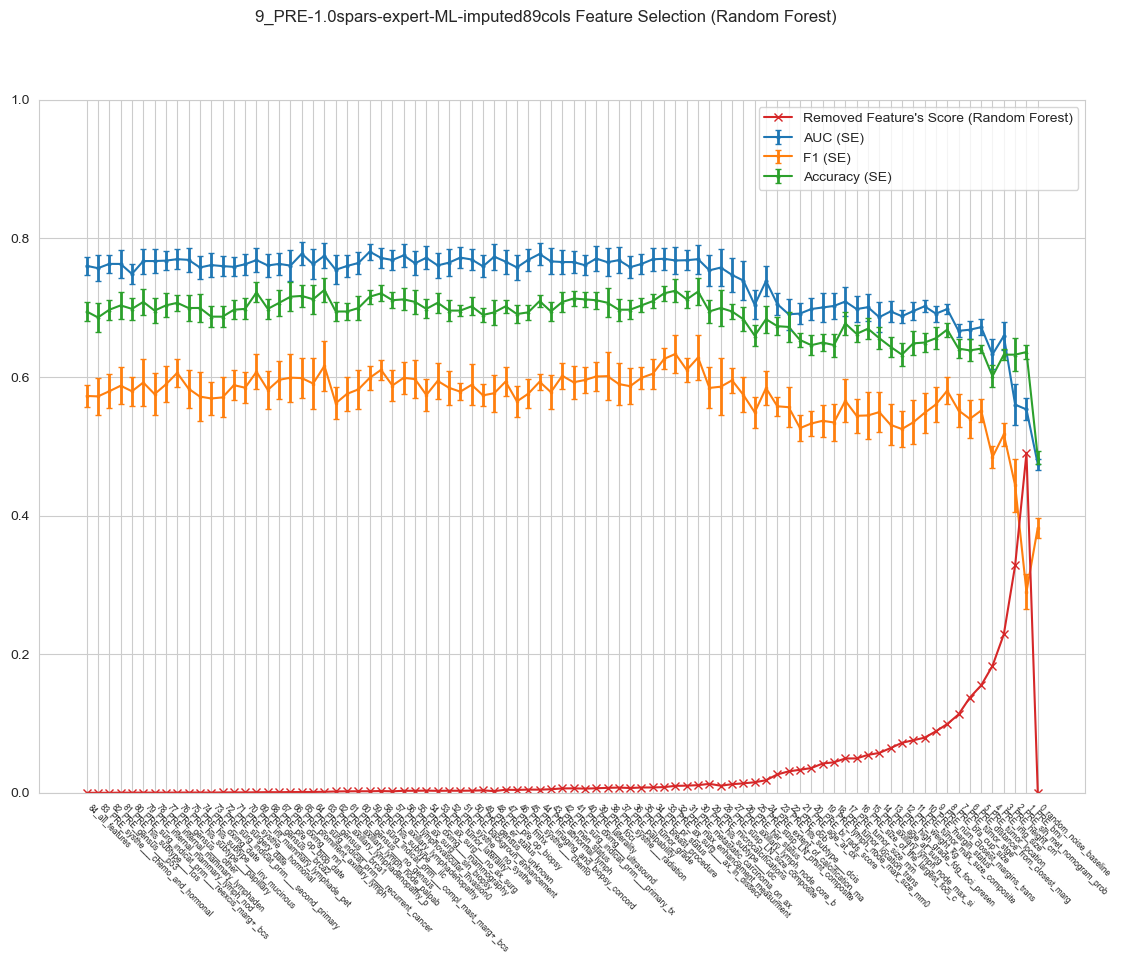

Processing E_POS-1.0spars-expert-ML-imputed132cols with top-126 features out of 126. This feature is all features.
E_POS-1.0spars-expert-ML-imputed132cols has 20073 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                                Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
E_POS-1.0spars-expert-ML-imputed132cols Logistic Regression       0.7818      0.0112  0.8373  0.0105  0.7242   0.011
E_POS-1.0spars-expert-ML-imputed132cols       Random Forest       0.8093      0.0136  0.8774  0.0147  0.7505  0.0225
E_POS-1.0spars-expert-ML-imputed132cols             XGBoost       0.7918      0.0143  0.8693  0.0136  0.7267  0.0255
------------------------------
Processing E_POS-1.0spars-expert-ML-imputed132cols with top-125 features out of 126. The last removed feature was PRE_systhe___chemo_and_hormonal.
E_POS-1.0spars-expert-ML-imputed132cols has 20073 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                                Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
E_POS-1.0spars-expert-ML-imputed132cols Logistic Regression       0.7806      0.0103  0.8371  0.0105  0.7248  0.0098
E_POS-1.0spars-expert-ML-imputed132cols       Random Forest       0.8068      0.0116  0.8759  0.0146  0.7399  0.0202
E_POS-1.0spars-expert-ML-imputed132cols             XGBoost       0.7906      0.0197   0.859  0.0158  0.7313  0.0269
------------------------------
Processing E_POS-1.0spars-expert-ML-imputed132cols with top-124 features out of 126. The last removed feature was PRE_gensus___p53.
E_POS-1.0spars-expert-ML-imputed132cols has 20073 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                                Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
E_POS-1.0spars-expert-ML-imputed132cols Logistic Regression       0.7781      0.0095  0.8365  0.0097  0.7215  0.0105
E_POS-1.0spars-expert-ML-imputed132cols       Random Forest        0.808      0.0139  0.8728  0.0167  0.7462  0.0229
E_POS-1.0spars-expert-ML-imputed132cols             XGBoost       0.7868       0.013  0.8687   0.014  0.7216  0.0216
------------------------------
Processing E_POS-1.0spars-expert-ML-imputed132cols with top-123 features out of 126. The last removed feature was PRE_surg_indicat_prim___second_primary.
E_POS-1.0spars-expert-ML-imputed132cols has 20073 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                                Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
E_POS-1.0spars-expert-ML-imputed132cols Logistic Regression       0.7806      0.0071  0.8384  0.0098  0.7252  0.0088
E_POS-1.0spars-expert-ML-imputed132cols       Random Forest       0.8105      0.0174   0.877  0.0169   0.746  0.0274
E_POS-1.0spars-expert-ML-imputed132cols             XGBoost       0.7906       0.015  0.8664  0.0173  0.7257  0.0225
------------------------------
Processing E_POS-1.0spars-expert-ML-imputed132cols with top-122 features out of 126. The last removed feature was PRE_surg_indicat_prim___reexcis_marg+_bcs.
E_POS-1.0spars-expert-ML-imputed132cols has 20073 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1... Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                                Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
E_POS-1.0spars-expert-ML-imputed132cols Logistic Regression       0.7893      0.0093  0.8431  0.0118  0.7351   0.011
E_POS-1.0spars-expert-ML-imputed132cols       Random Forest        0.818      0.0181  0.8708  0.0161  0.7556  0.0268
E_POS-1.0spars-expert-ML-imputed132cols             XGBoost       0.7981      0.0244   0.862  0.0175  0.7376  0.0367
------------------------------
Processing E_POS-1.0spars-expert-ML-imputed132cols with top-121 features out of 126. The last removed feature was POS_his_type___lcis.
E_POS-1.0spars-expert-ML-imputed132cols has 20073 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                                Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
E_POS-1.0spars-expert-ML-imputed132cols Logistic Regression       0.7856      0.0053  0.8434  0.0115  0.7281  0.0076
E_POS-1.0spars-expert-ML-imputed132cols       Random Forest       0.8155      0.0148  0.8747  0.0142  0.7547  0.0221
E_POS-1.0spars-expert-ML-imputed132cols             XGBoost       0.7956      0.0179  0.8585  0.0156  0.7333  0.0258
------------------------------
Processing E_POS-1.0spars-expert-ML-imputed132cols with top-120 features out of 126. The last removed feature was PRE_internal_mammary_lymphaden.
E_POS-1.0spars-expert-ML-imputed132cols has 20073 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



                                Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
E_POS-1.0spars-expert-ML-imputed132cols Logistic Regression       0.7856      0.0089  0.8437  0.0121  0.7316  0.0107
E_POS-1.0spars-expert-ML-imputed132cols       Random Forest        0.813      0.0163  0.8772  0.0149  0.7494  0.0246
E_POS-1.0spars-expert-ML-imputed132cols             XGBoost       0.7856      0.0194  0.8549  0.0182  0.7206  0.0276
------------------------------
Processing E_POS-1.0spars-expert-ML-imputed132cols with top-119 features out of 126. The last removed feature was POS_his_type___other.
E_POS-1.0spars-expert-ML-imputed132cols has 20073 missing values before imputing.


/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Fold 1... 

/Users/yifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2... 

KeyboardInterrupt: 

In [12]:
# Backward step-wise feature selection

# Conduct experiments for determining the cumulative effect of the features on the model performance
# For each dataset, train the models on the top-k most important feature, then top-(k-1), top-(k-2), ...
def backward_feature_selection(all_top_features, model_name, target_column, metrics_df, plot_dict3, plot_dir, standardize, num_folds=3, impute_max_iter=30):
    
    for df_name in all_top_features:
        if not ("1.0" in df_name):
            continue
        # Create a DataFrame for the top-k most important feature
        # Sort all features by feature scores
        all_features_sorted = [f[0] for f in sorted(all_top_features[df_name][model_name].items(), key=lambda x: x[1], reverse=True)]
        num_features = len(all_features_sorted)
        df_all_features = dfs_std[df_name]
        df_all_features = df_all_features.dropna(axis=1, how="all")
        # If standardize is True, standardize the data
        if standardize:
            df_all_features = standardize_data(df_all_features)
        # Keep track of the bottom feature scores
        lowest_feature_scores = [0]
        lowest_feature_names = []
        for k in range(num_features, -1, -1):
            if k == 0:
                # Random noise baseline
                top_k_features = "random_noise_baseline"
                lowest_feature_names.append("0_random_noise_baseline")
                print_and_log(f"Processing {df_name} with top-{k} features out of {num_features}. This feature is random noise baseline.")
                df_top_k_features = df_all_features[[target_column]]
                noise_data = np.random.rand(len(df_top_k_features))
                df_top_k_features.insert(0, "0_random_noise_baseline", noise_data)
                assert len(df_top_k_features.columns) == 2
                lowest_feature_scores.append(0)
            elif k == num_features:
                top_k_features = f"{k}_all_features"
                lowest_feature_names.append(top_k_features)
                print_and_log(f"Processing {df_name} with top-{k} features out of {num_features}. This feature is all features.")
                df_top_k_features = df_all_features.copy()
                assert len(df_top_k_features.columns) == num_features + 1
            else:
                # Assert feature scores are sorted in descending order
                assert list(feature_scores.items()) == list(sorted(feature_scores.items(), key=lambda x: x[1], reverse=True))
                # Keep the top-k features and remove the rest, using feature_scores from previous iteration
                top_k_features = list(feature_scores.keys())[:-1]
                removed_feature = list(feature_scores.keys())[-1]
                assert len(top_k_features) == k
                lowest_feature_scores.append(feature_scores[removed_feature])
                lowest_feature_names.append(f"{k}_{removed_feature}")
                print_and_log(f"Processing {df_name} with top-{k} features out of {num_features}. The last removed feature was {removed_feature}.")
                # Create a DataFrame for the top-k most important features, and the target variable
                df_top_k_features = df_all_features[top_k_features + [target_column]]
                assert len(df_top_k_features.columns) == k + 1
                assert removed_feature not in df_top_k_features.columns
            # Print the number of missing values in df_top_k_features if any
            if df_top_k_features.isnull().values.any():
                print_and_log(f"{df_name} has {df_top_k_features.isnull().sum().sum()} missing values before imputing.")
            # Impute missing values in df_top_k_features using Random Forest
            df_top_k_features_imputed = impute_missing_value(df_top_k_features, target_column, max_iter=impute_max_iter)
            assert df_top_k_features_imputed.isnull().values.any() == False
            metrics_df, feature_scores = build_classifiers(df_top_k_features_imputed, df_name, num_folds=num_folds)
            # Keep feature scores from chosen model_name only, format is {"top-1st-feature": score1, "top-2nd-feature": score2, ...}
            feature_scores = feature_scores[model_name] 
            # Assert feature scores are sorted in descending order
            assert list(feature_scores.items()) == list(sorted(feature_scores.items(), key=lambda x: x[1], reverse=True))
            # print metrics_df, without index
            print_and_log("")
            print_and_log(metrics_df.to_string(index=False, justify="right"))
            print_and_log("-"*30)
            # Add the DataFrame to the dictionary for plotting later
            plot_dict3[df_name][k] = metrics_df
            # Sleep for a few seconds to cool down the hardware
            time.sleep(3)
        print("="*150)
        # Plot the metrics on the top-k most important features
        # The X-axis is the number of features, with the kth feature as label
        # The Y-axis is the metrics, with three types of metrics shown in separate markers
        # The Y-axis also shows the metric scores for each feature
        # The metrics are AUC, F1, and Accuracy, which are saved in metrics_df
        # The legend is the type of the metric
        # Use tight layout
        plt.tight_layout()
        fig, ax = plt.subplots()
        # Set the title of the figure
        fig.suptitle(f"{df_name} Feature Selection ({model_name})")
        marker_map = {"AUC": "o", "F1": "s", "Accuracy": "^"}
        for metric_name in ["AUC", "F1", "Accuracy"]:
            # Create figure
            plt_name = f"{df_name}_top_features_metrics.png"
            # x_data = [i for i in range(1, num_features+1)]
            # Append the feature name to each x_data
            # x_data = ["0_random_noise_baseline"] + [f"{i}_{all_features_sorted[i-1]}" for i in x_data]
            x_data = lowest_feature_names
            model_idx = metrics_df["Model"].values.tolist().index(model_name)
            y_data = []
            y_err = []
            for metrics_df in plot_dict3[df_name].values():
                # Get the data for plotting
                y_data.append(metrics_df["Avg " + metric_name].values[model_idx])
                y_err.append(metrics_df["SE " + metric_name].values[model_idx])
            # Plot the data
            ax.errorbar(
                x_data,
                y_data,
                yerr=y_err,
                marker=marker_map[metric_name],
                label=metric_name + " (SE)",
                ms=2,
                capsize=2,
                barsabove=True,
                elinewidth=2
            )

        ax.plot(x_data, lowest_feature_scores, marker="x", label=f"Removed Feature's Score ({model_name})")
        # Set the marker size to smaller sizes so error bars can be seen
        # Make the x-axis labels smaller if len_x_data is too long
        x_tick_size = 10 if len(x_data) < 30 else 6
        plt.xticks(rotation=-45, ha="left", size=x_tick_size)
        # Add legend
        ax.legend(loc="best")
        # Enforce the range of the y-axis
        ax.set_ylim(0, 1.0)
        fig.set_size_inches(len(x_data) * 0.1 + 5, 9)
        # Show major gridlines
        ax.grid(True, which="major", linestyle="-")
        # Show minor gridlines
        ax.grid(True, which="minor", linestyle="--", alpha=0.2)
        plt.show()
        # Save the figure
        # Adjust plot size, let the width be proportional to the length of x-data
        plt_path = os.path.join(plot_dir, plt_name)
        fig.tight_layout()
        fig.savefig(plt_path, dpi=500)
        

for standardize in True, False:
    dir_name = "plots_backward_selection_standardized" if standardize else "plots_backward_selection_not_standardized"
    plot_dir_backwards = os.path.join(dir_to_df, dir_name) 
    # Create the directory if it doesn't exist
    if not os.path.exists(plot_dir_backwards):
        os.makedirs(plot_dir_backwards)

    model_name = "Random Forest"
    target_column = "POS_did_the_patient_receive_pm"
    metrics_df = pd.DataFrame(columns=metrics_df_columns)
    # Create a dictionary for holding the DataFrames for plotting
    # Schema: {"Dataset1": {"TopK_feature": metrics_df1, "Top(K-1)_feature": metrics_df2, ...}, ...}
    plot_dict3 = defaultdict(OrderedDict)
    # Re-use the all_top_features dictionary for deciding the order of the features to use
    backward_feature_selection(all_top_features, model_name, target_column, metrics_df, plot_dict3, plot_dir_backwards, standardize=False, num_folds=5, impute_max_iter=100)